# ML4EO - Team 2

> Summer School in Pavia, 2023.06.05. - 2023.06.09.

This is the notebook for the BIP course Machine Learning for Earth Observation. The members of Team 2 are the following:

- Team Lead: Jules Bourcier
- Dario Perregrini
- Patricia Camparada
- Olivér Angyal

## Topic

Monitoring the water extents of the Po River flowing south of Cremona during Spring-Summer 2022 (the lack of precipitations and the severe drought resulted in a big reduction of the water content in the river, down by more to -8 m w.r.t. the usual level).

> Team specific task: monitoring water extents with **multispectral sensors**

## Datasets


In [377]:
import pandas as pd
import numpy as np

### Ancillary data


In [3]:
!pip install --no-cache-dir torch torchvision --quiet
!pip install gdown --quiet
!gdown 1m3oRkElw3WGTwfrHbnD2iQKXz-FlfIga # ancillary data

Downloading...
From: https://drive.google.com/uc?id=1m3oRkElw3WGTwfrHbnD2iQKXz-FlfIga
To: /Users/oliverangyal/Development/bip-ml4eo/src/Cremona SIAP - Livello Idrometrico - 2023-01-12.csv
100%|████████████████████████████████████████| 309k/309k [00:00<00:00, 4.30MB/s]


In [378]:
ancillary_data_path = "/Users/oliverangyal/Development/bip-ml4eo/Cremona SIAP - Livello Idrometrico - 2023-01-12.csv"

ancillary_df = pd.read_csv(ancillary_data_path, sep=";")
ancillary_df.rename(
    columns={
        "Orario": "Hours",
        "Cremona SIAP - Livello Idrometrico - 15970 (m)": "Hydrometric level",
        "Variazione": "Variation",
        "Valore assoluto": "Absolute value",
    },
    inplace=True,
)
ancillary_df.head()

,Hours,Hydrometric level,Variation,Absolute value
0,2022-01-12 01:00,-6.64,NaN,-6.64
1,2022-01-12 02:00,-6.64,0.00,-6.64
2,2022-01-12 03:00,-6.64,0.00,-6.64
3,2022-01-12 04:00,-6.65,-0.01,-6.65
4,2022-01-12 05:00,-6.65,0.00,-6.65


In [5]:
print(f"Number of data points: {len(ancillary_df)}")

Number of data points: 8778


In [379]:
ancillary_df["Hours"] = pd.to_datetime(ancillary_df["Hours"])
ancillary_df.sort_values("Hours", inplace=True)

In [380]:
timestamp_s = ancillary_df["Hours"].map(pd.Timestamp.timestamp)
ancillary_df["Timestamp_s"] = timestamp_s

In [381]:
hour = 60 * 60
day = 24 * 60 * 60
month = (365.2425 / 12) * day
year = (365.2425) * day

ancillary_df["Hour sin"] = np.sin(timestamp_s * (2 * np.pi / hour))
ancillary_df["Hour cos"] = np.cos(timestamp_s * (2 * np.pi / hour))
ancillary_df["Day sin"] = np.sin(timestamp_s * (2 * np.pi / day))
ancillary_df["Day cos"] = np.cos(timestamp_s * (2 * np.pi / day))
ancillary_df["Month sin"] = np.sin(timestamp_s * (2 * np.pi / month))
ancillary_df["Month cos"] = np.cos(timestamp_s * (2 * np.pi / month))
ancillary_df["Year sin"] = np.sin(timestamp_s * (2 * np.pi / year))
ancillary_df["Year cos"] = np.cos(timestamp_s * (2 * np.pi / year))

Text(0.5, 1.0, 'Time of day signal')

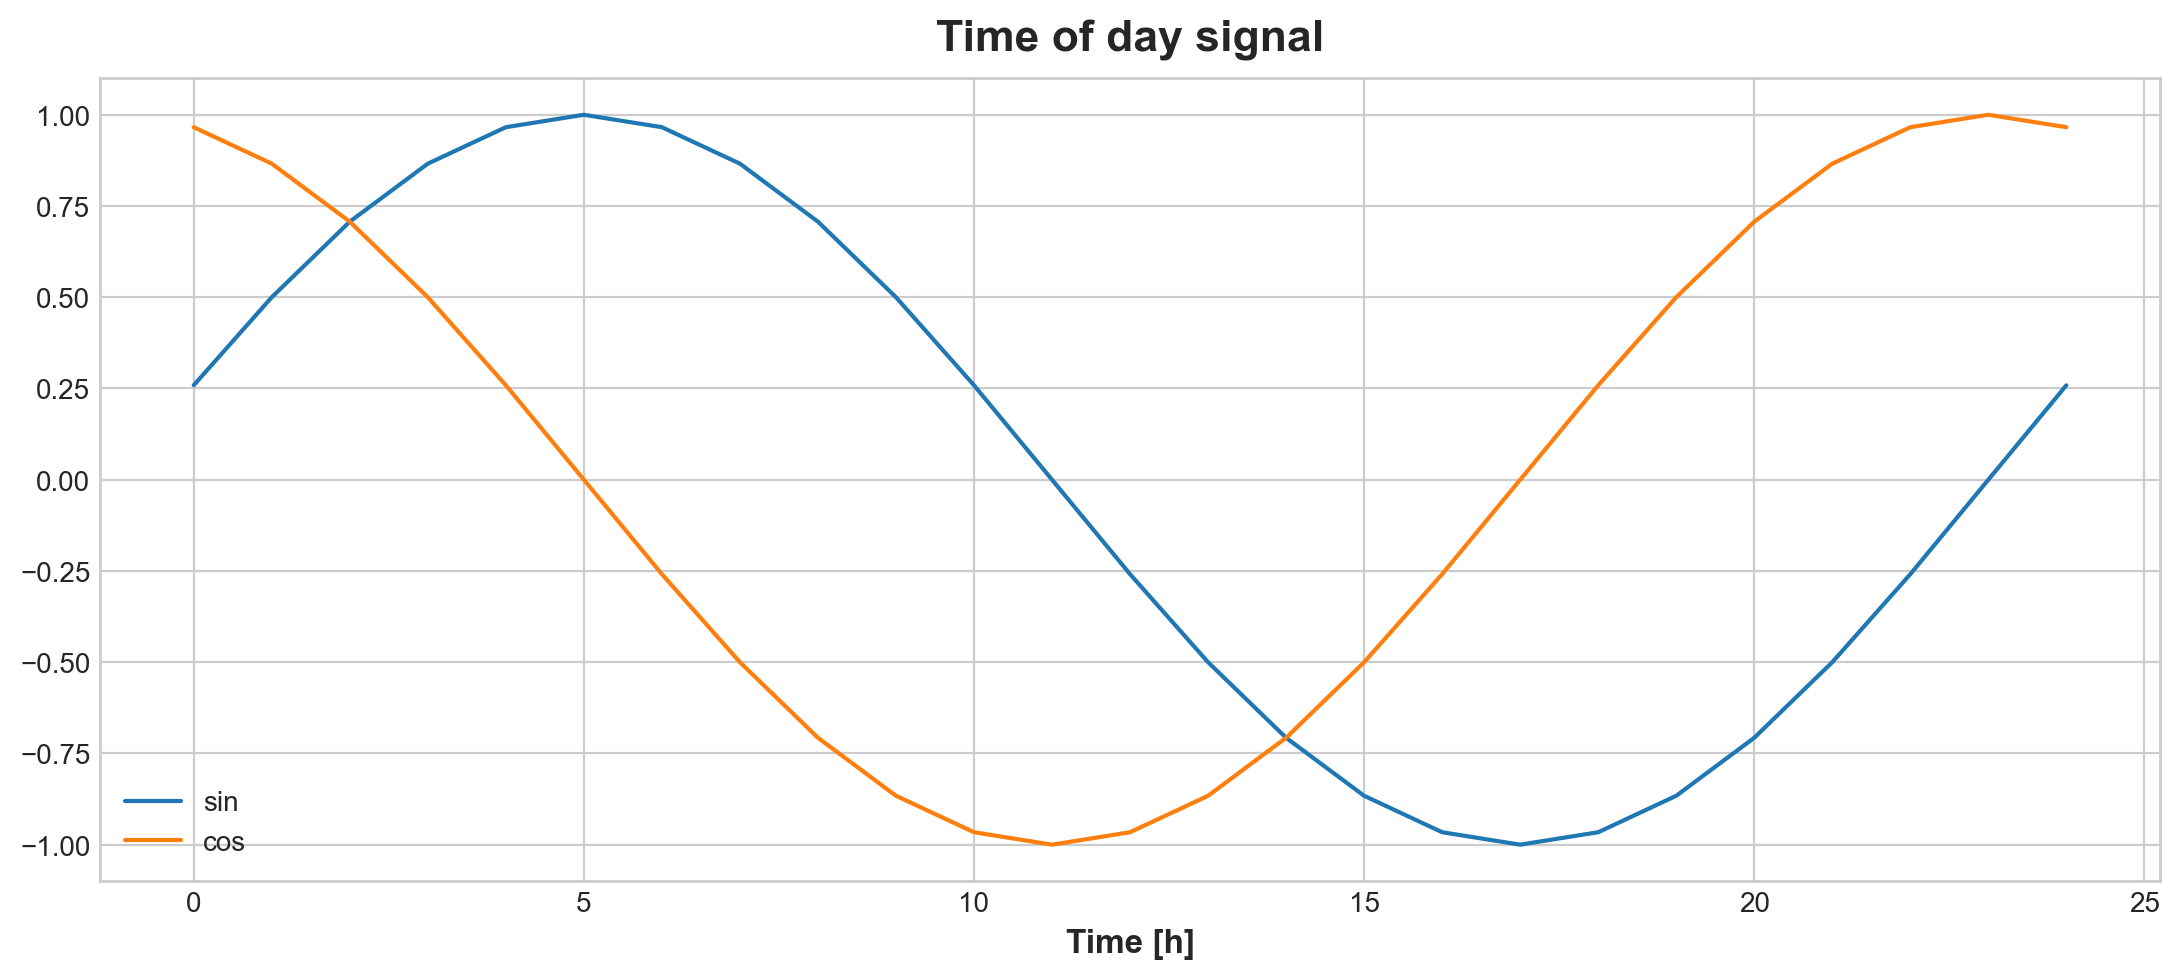

In [382]:
import matplotlib.pyplot as plt

plt.plot(np.array(ancillary_df["Day sin"])[:25])
plt.plot(np.array(ancillary_df["Day cos"])[:25])
plt.legend(["sin", "cos"])
plt.xlabel("Time [h]")
plt.title("Time of day signal")

In [383]:
ancillary_df["Hydrometric level"] = ancillary_df["Hydrometric level"].replace(
    "", np.nan
)
ancillary_df.loc[ancillary_df["Hydrometric level"] == "-", "Hydrometric level"] = np.nan
ancillary_df["Hydrometric level"] = ancillary_df["Hydrometric level"].astype(float)

In [384]:
print(
    "Hydrometric level missing values: ",
    ancillary_df["Hydrometric level"].isnull().sum(),
)

Hydrometric level missing values:  78


In [385]:
ancillary_df.loc[ancillary_df["Variation"] == "-", "Variation"] = np.nan
ancillary_df["Variation"] = ancillary_df["Variation"].astype(float)

In [386]:
print("Variation missing values: ", ancillary_df["Variation"].isnull().sum())

Variation missing values:  91


In [387]:
ancillary_df["Absolute value"] = ancillary_df["Absolute value"].abs()
print("Absolute value missing values: ", ancillary_df["Absolute value"].isnull().sum())

Absolute value missing values:  78


<AxesSubplot: xlabel='Hours'>

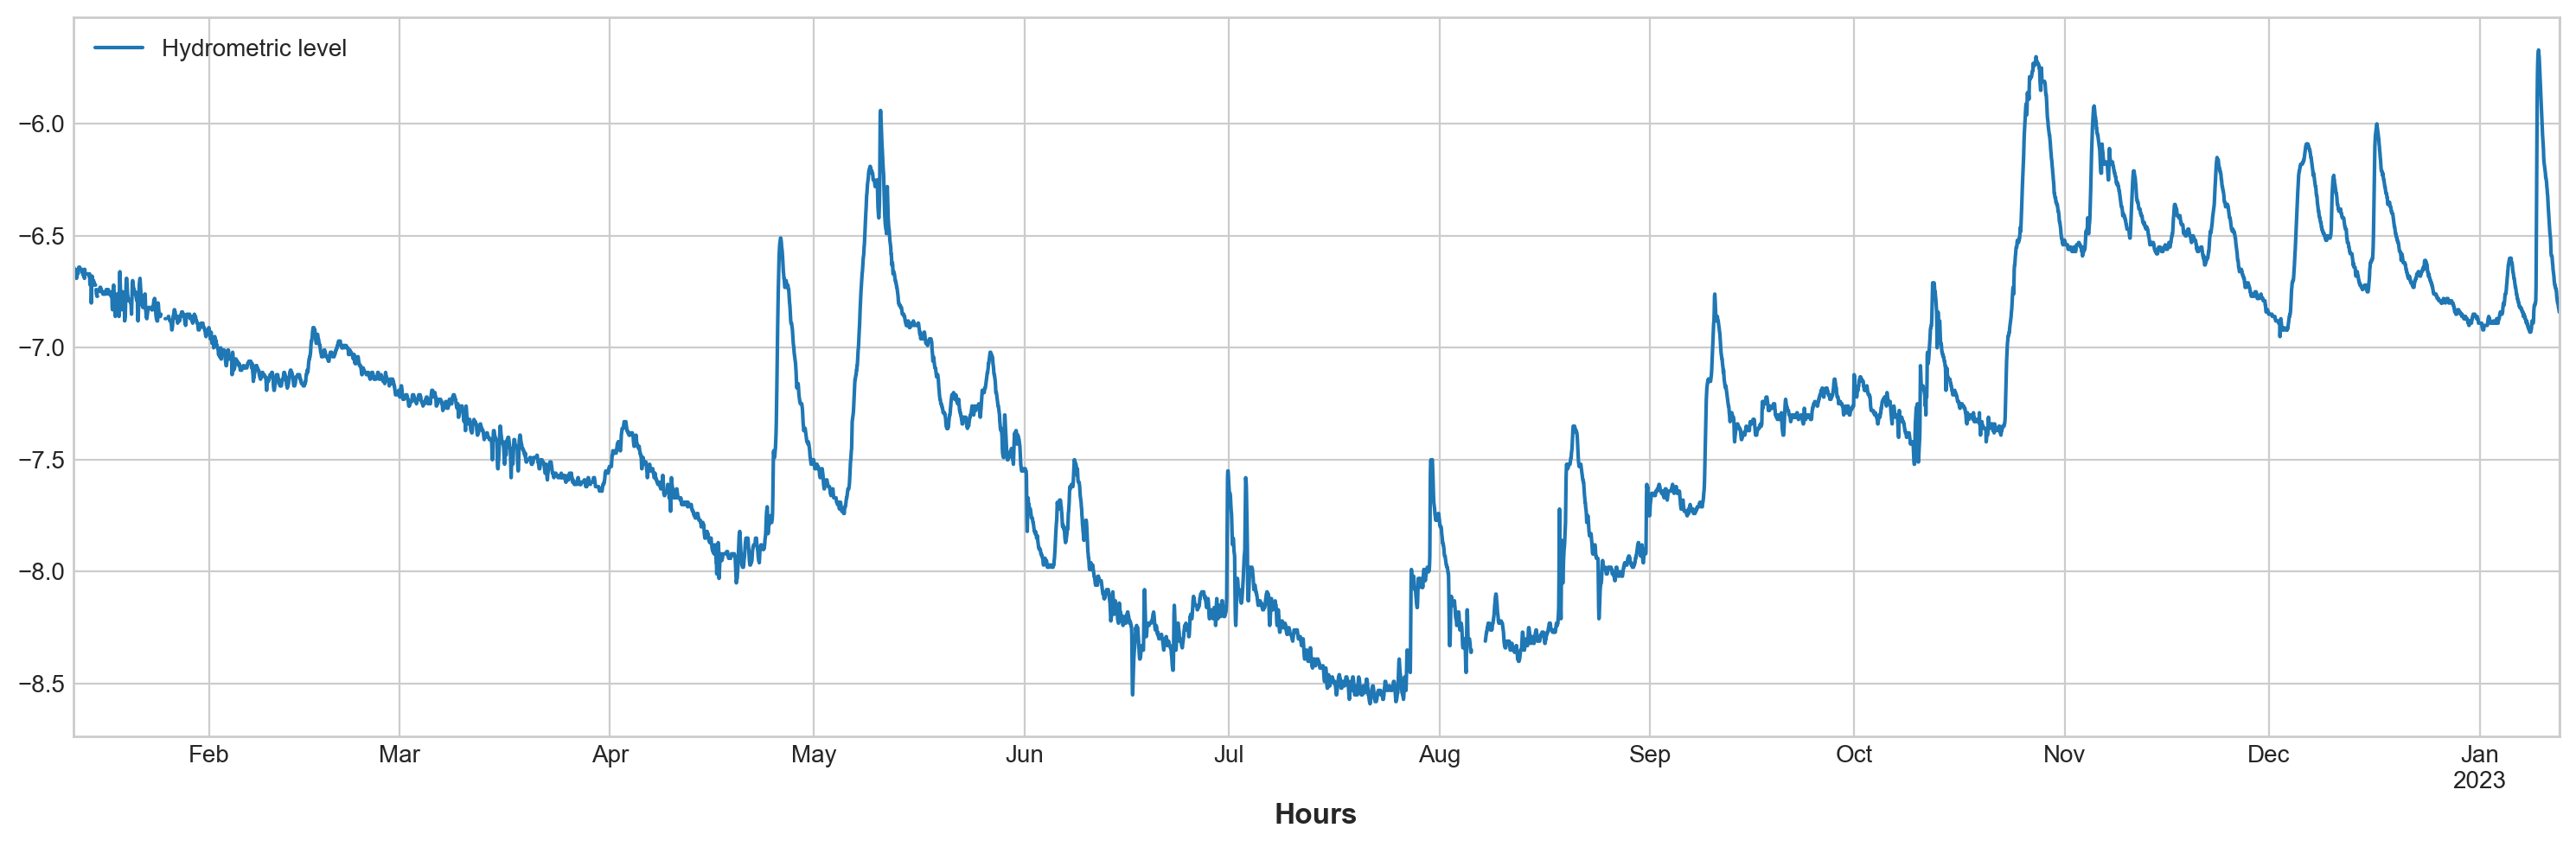

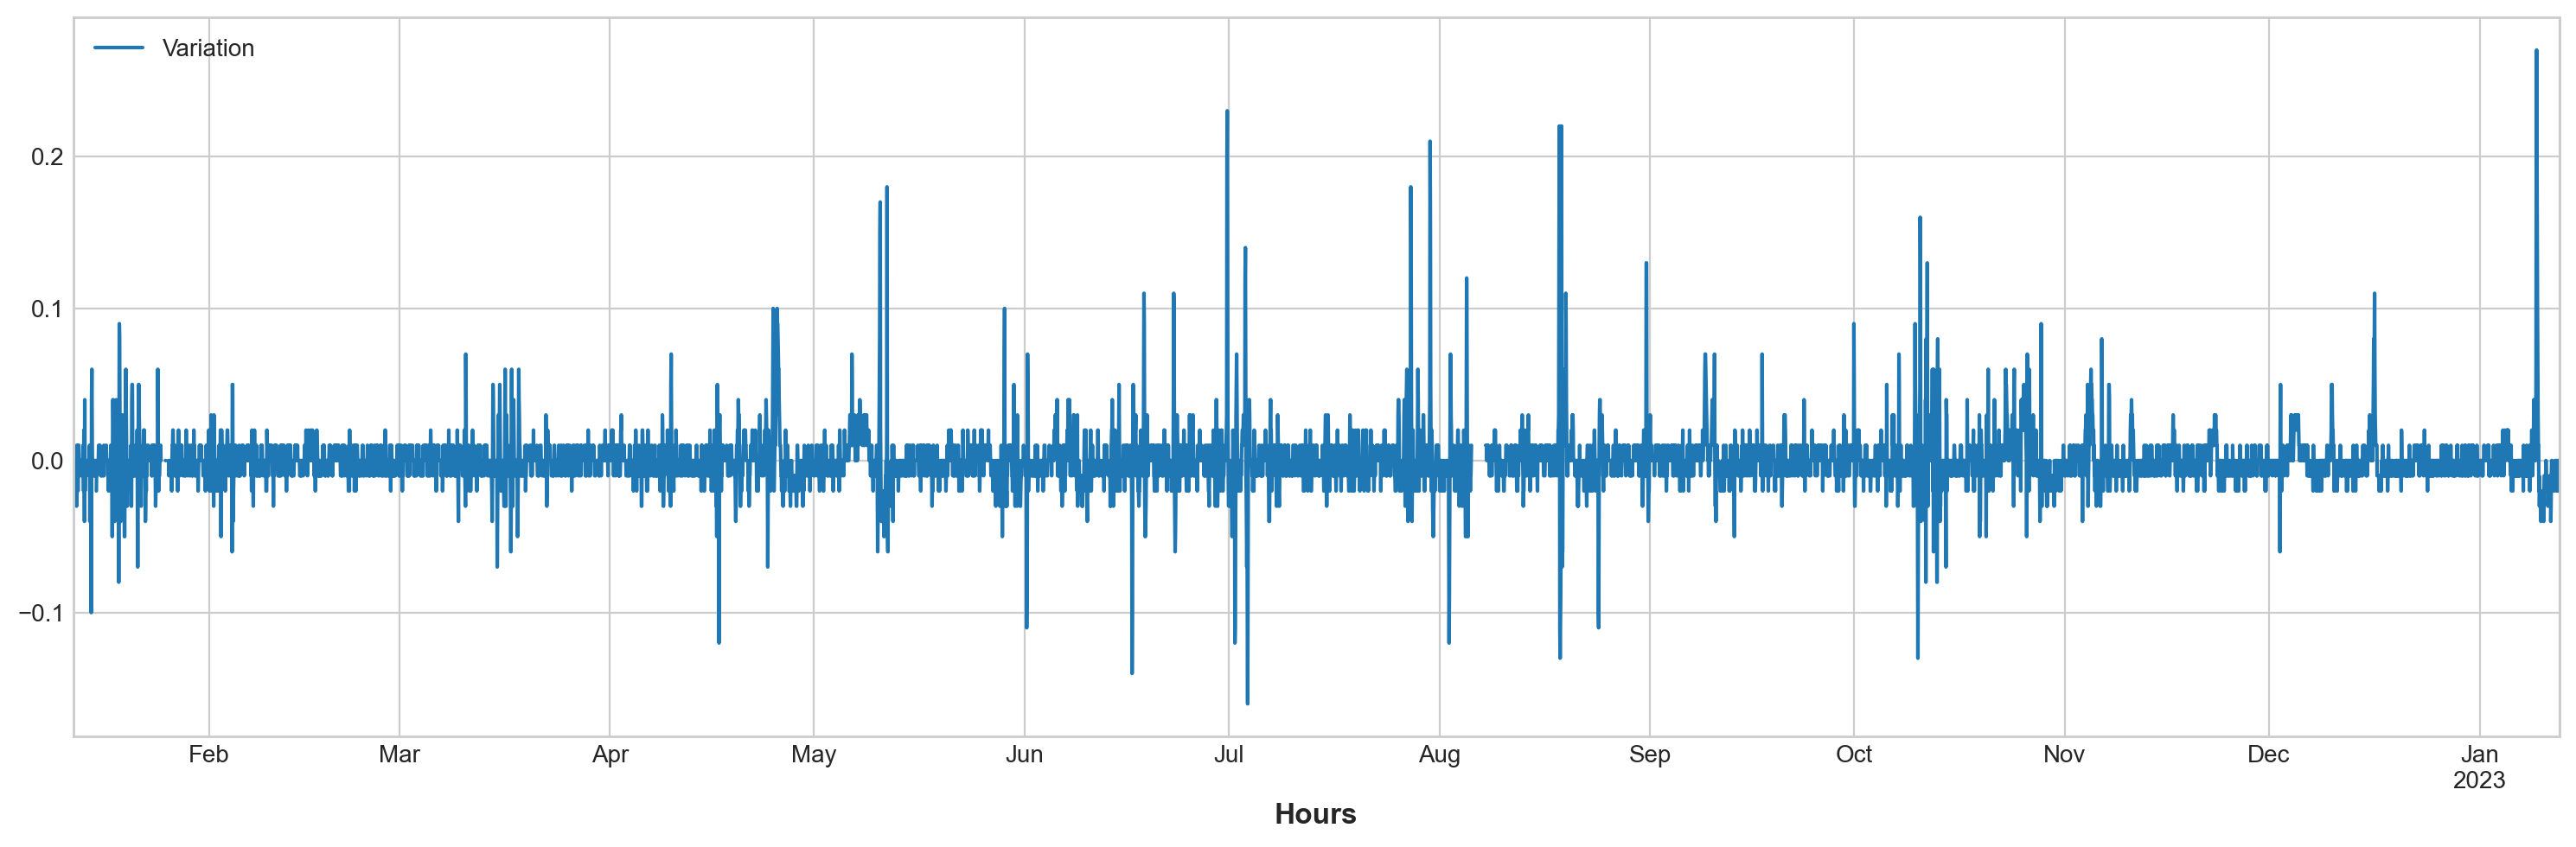

In [388]:
ancillary_df[["Hours", "Hydrometric level"]].set_index("Hours").plot(figsize=(15, 5))

ancillary_df[["Hours", "Variation"]].set_index("Hours").plot(figsize=(15, 5))

<AxesSubplot: xlabel='Hours'>

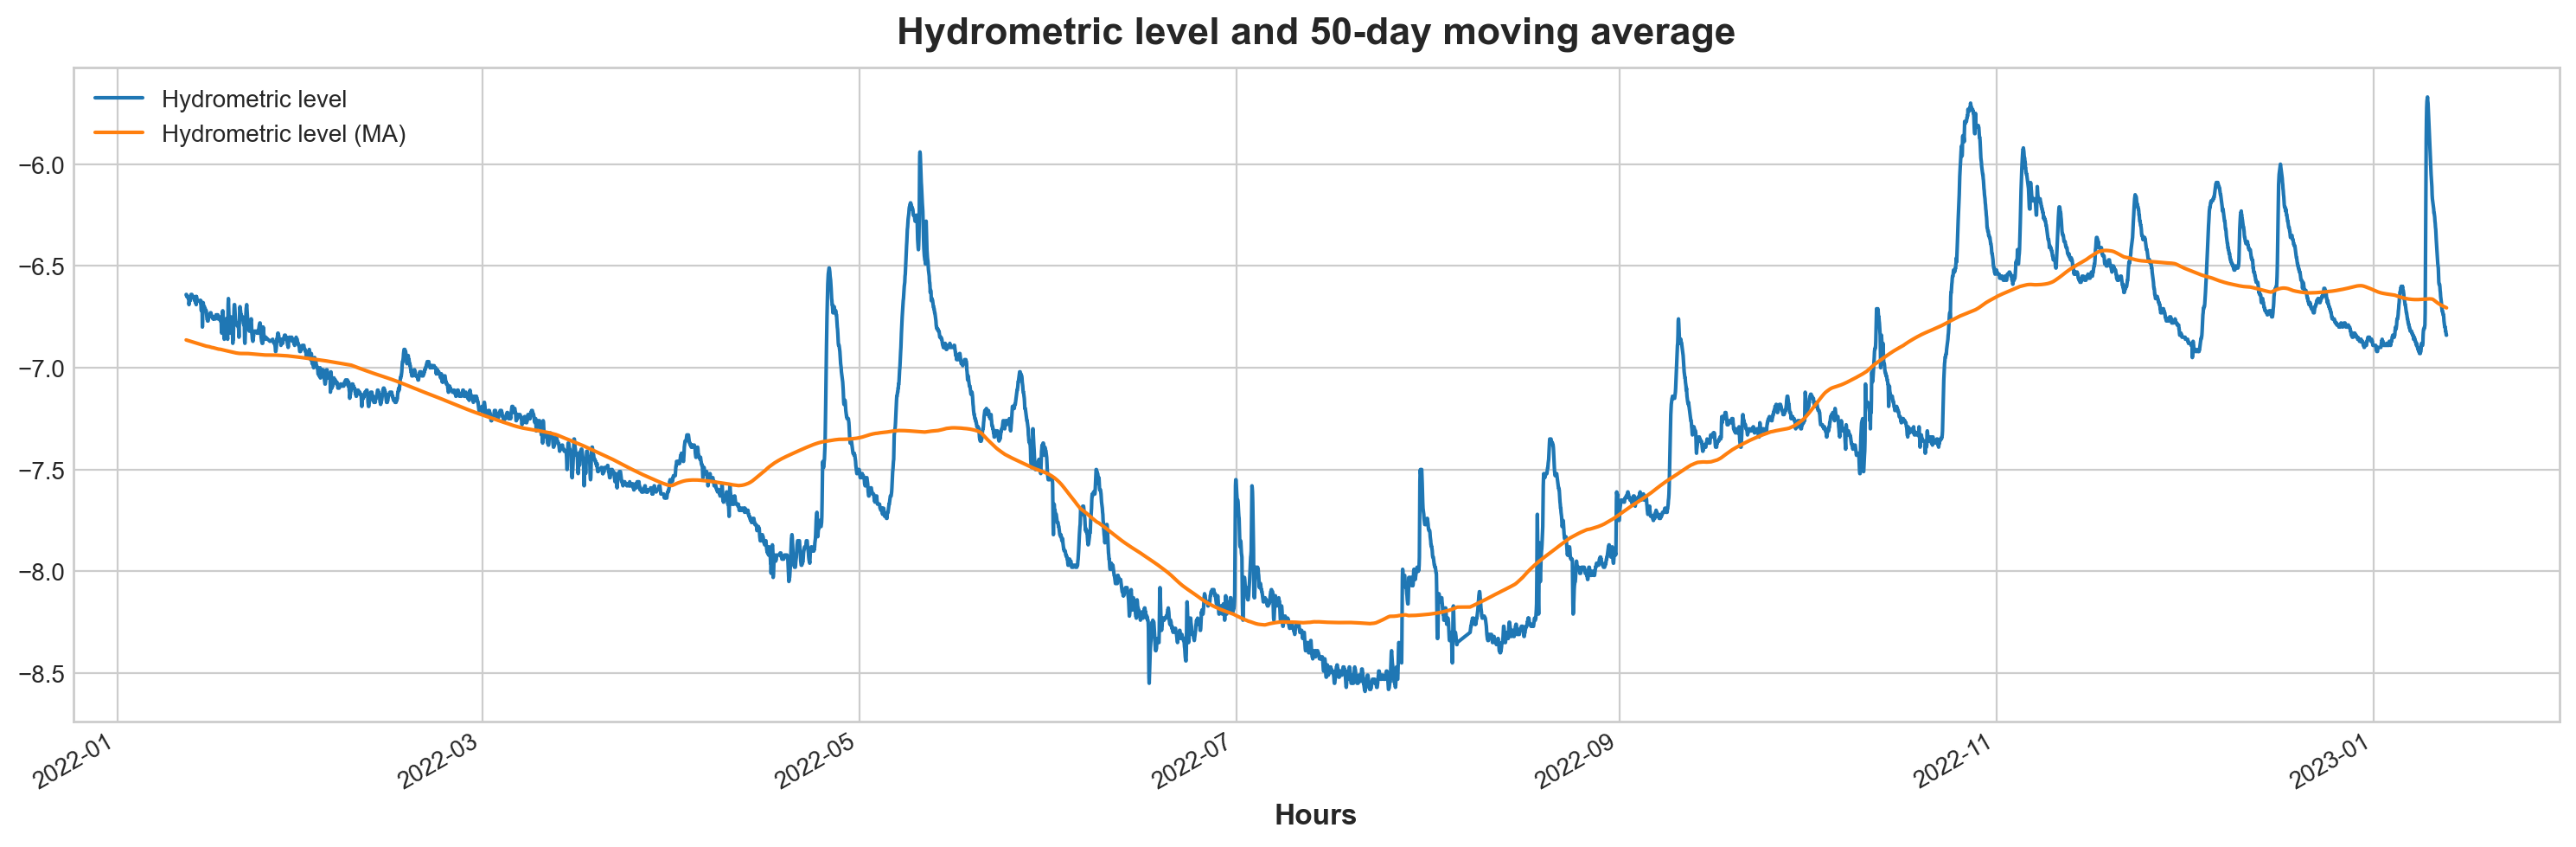

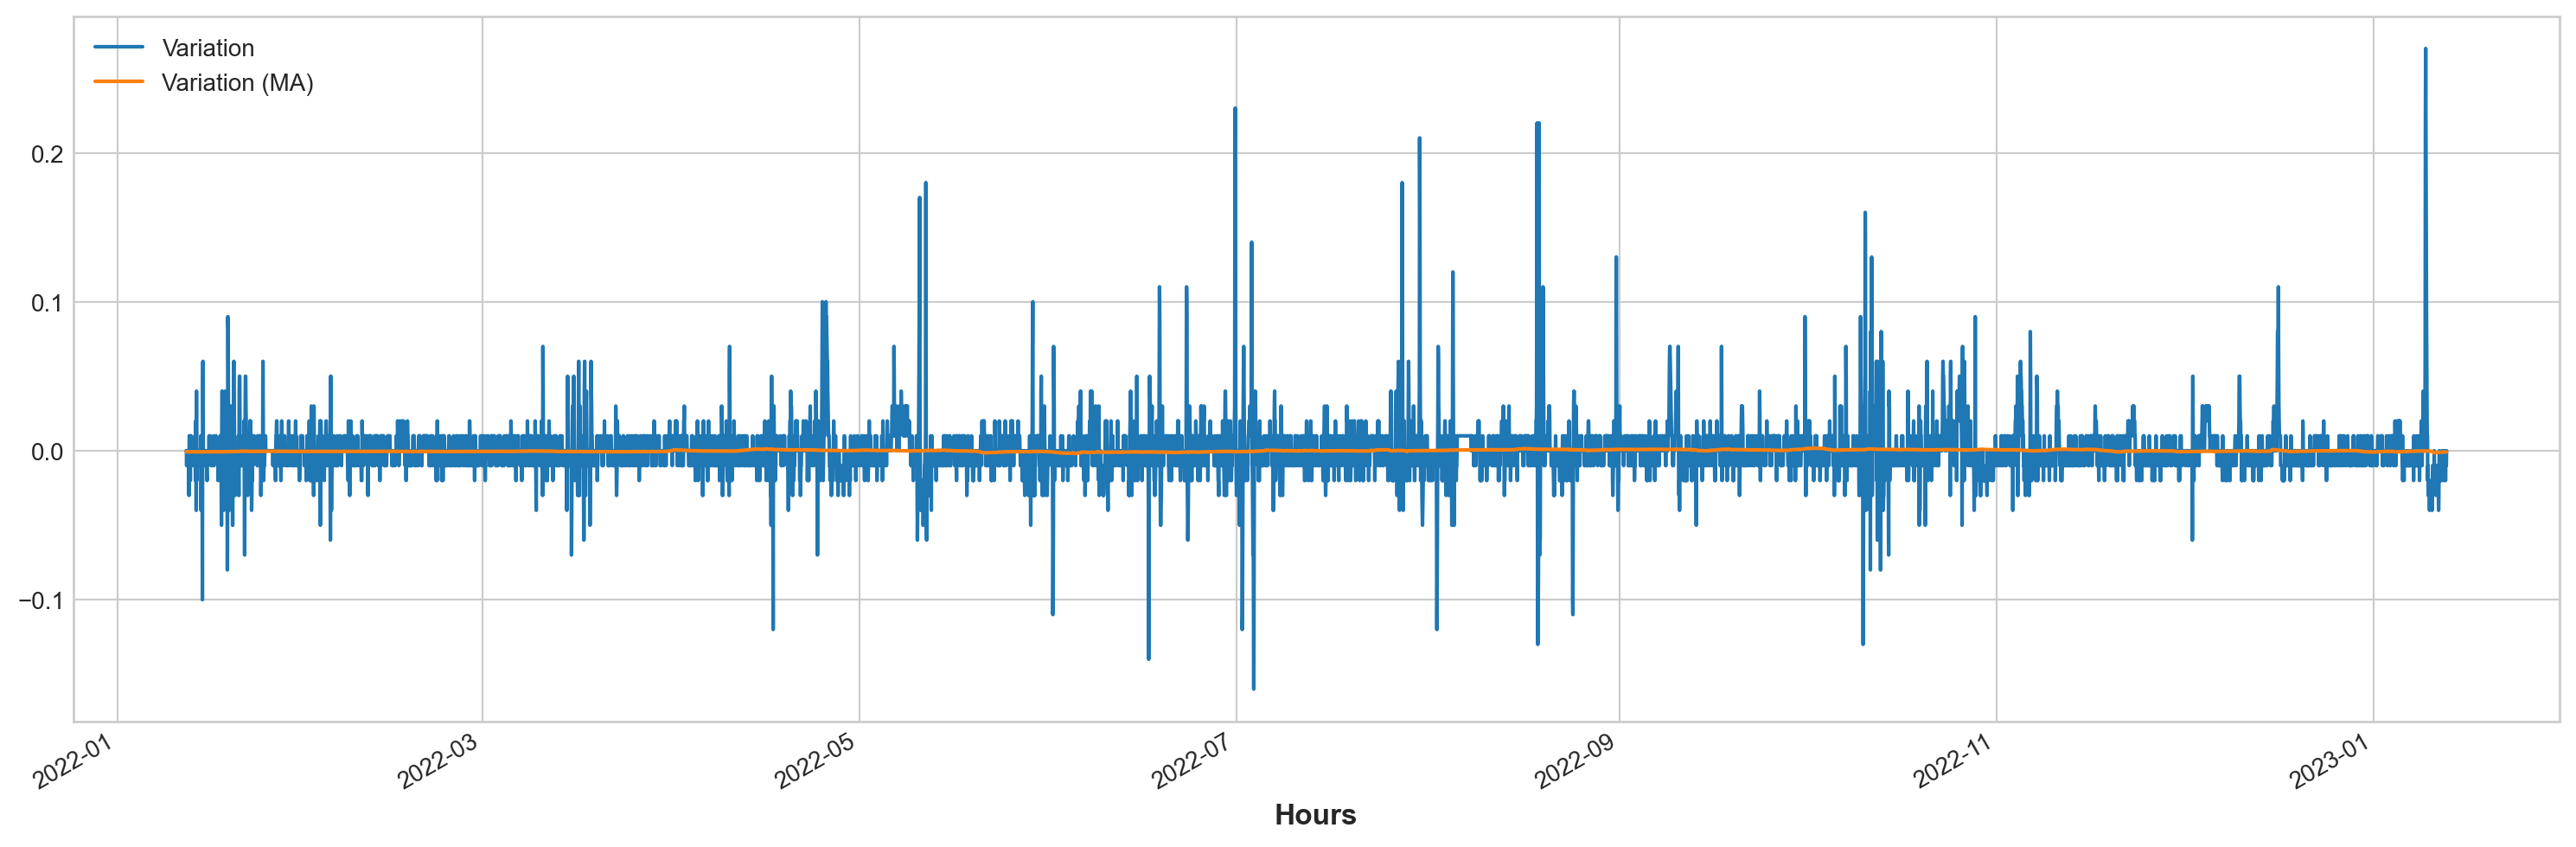

In [391]:
# moving average for Hydrometric level

moving_average_df = ancillary_df[["Hours", "Hydrometric level", "Variation"]].copy()

moving_average_df.dropna(inplace=True)

moving_average_df["Hydrometric level (MA)"] = (
    moving_average_df["Hydrometric level"]
    .rolling(window=1200, center=True, min_periods=600)
    .mean()
)

moving_average_df["Variation (MA)"] = (
    moving_average_df["Variation"]
    .rolling(window=1200, center=True, min_periods=600)
    .mean()
)

ax = (
    moving_average_df[["Hours", "Hydrometric level"]]
    .set_index("Hours")
    .plot(figsize=(15, 5))
)
moving_average_df[["Hours", "Hydrometric level (MA)"]].set_index("Hours").plot(
    ax=ax, figsize=(15, 5), title="Hydrometric level and 50-day moving average"
)

ax = moving_average_df[["Hours", "Variation"]].set_index("Hours").plot(figsize=(15, 5))
moving_average_df[["Hours", "Variation (MA)"]].set_index("Hours").plot(
    ax=ax, figsize=(15, 5)
)

In [393]:
from pathlib import Path
from warnings import simplefilter

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

simplefilter("ignore")

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 5))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)
%config InlineBackend.figure_format = 'retina'


# annotations: https://stackoverflow.com/a/49238256/5769929
def seasonal_plot(X, y, period, freq, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    palette = sns.color_palette("husl", n_colors=X[period].nunique(),)
    ax = sns.lineplot(
        x=freq,
        y=y,
        hue=period,
        data=X,
        ci=False,
        ax=ax,
        palette=palette,
        legend=False,
    )
    ax.set_title(f"Seasonal Plot ({period}/{freq})")
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(
            name,
            xy=(1, y_),
            xytext=(6, 0),
            color=line.get_color(),
            xycoords=ax.get_yaxis_transform(),
            textcoords="offset points",
            size=14,
            va="center",
        )
    return ax


def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("1Y") / pd.Timedelta("1H")  # Changed from "1D" to "1H"
    frequencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(frequencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([24, 168, 720, 1440, 2880])
    ax.set_xticklabels(
        [
            "Daily (24)",
            "Weekly (168)",
            "Monthly (~720)",
            "Semi-Monthly (~1440)",
            "Bi-Weekly (~2880)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax

<AxesSubplot: title={'center': 'Periodogram'}, ylabel='Variance'>

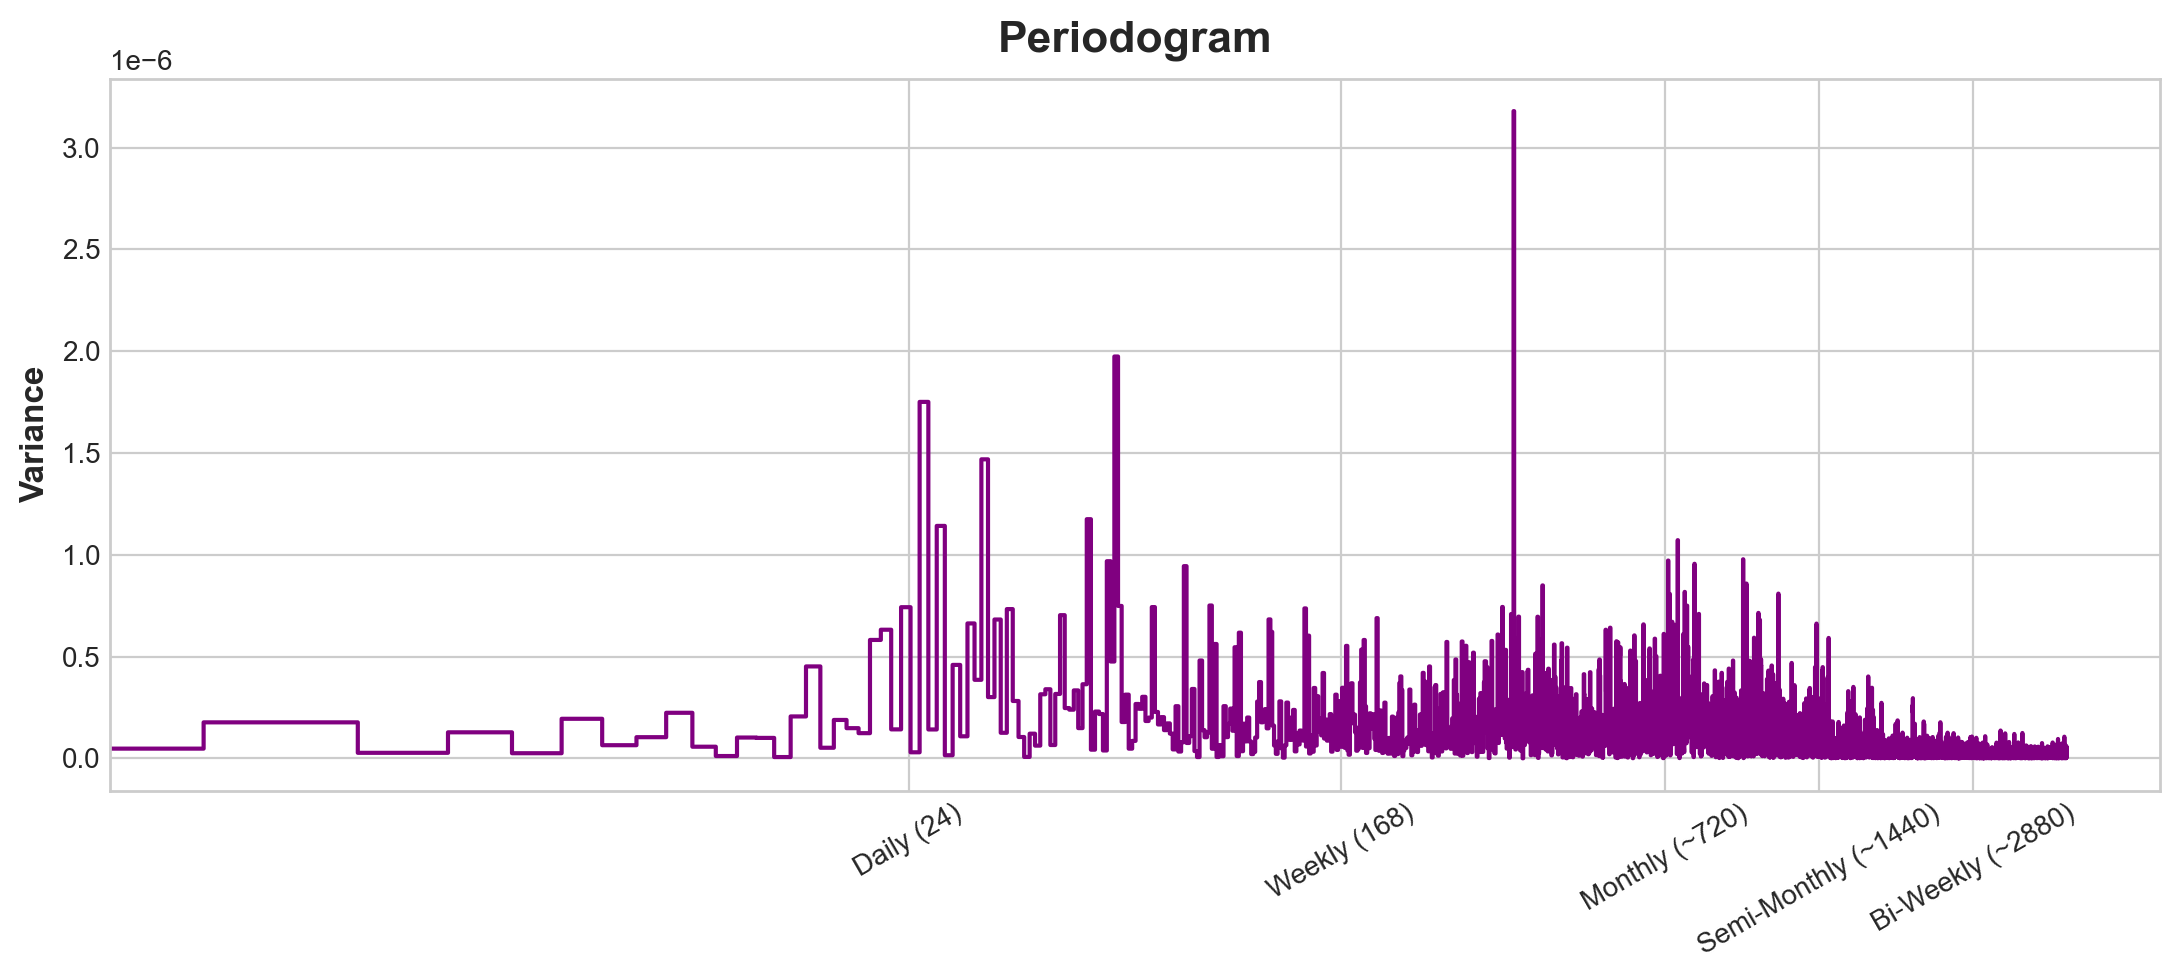

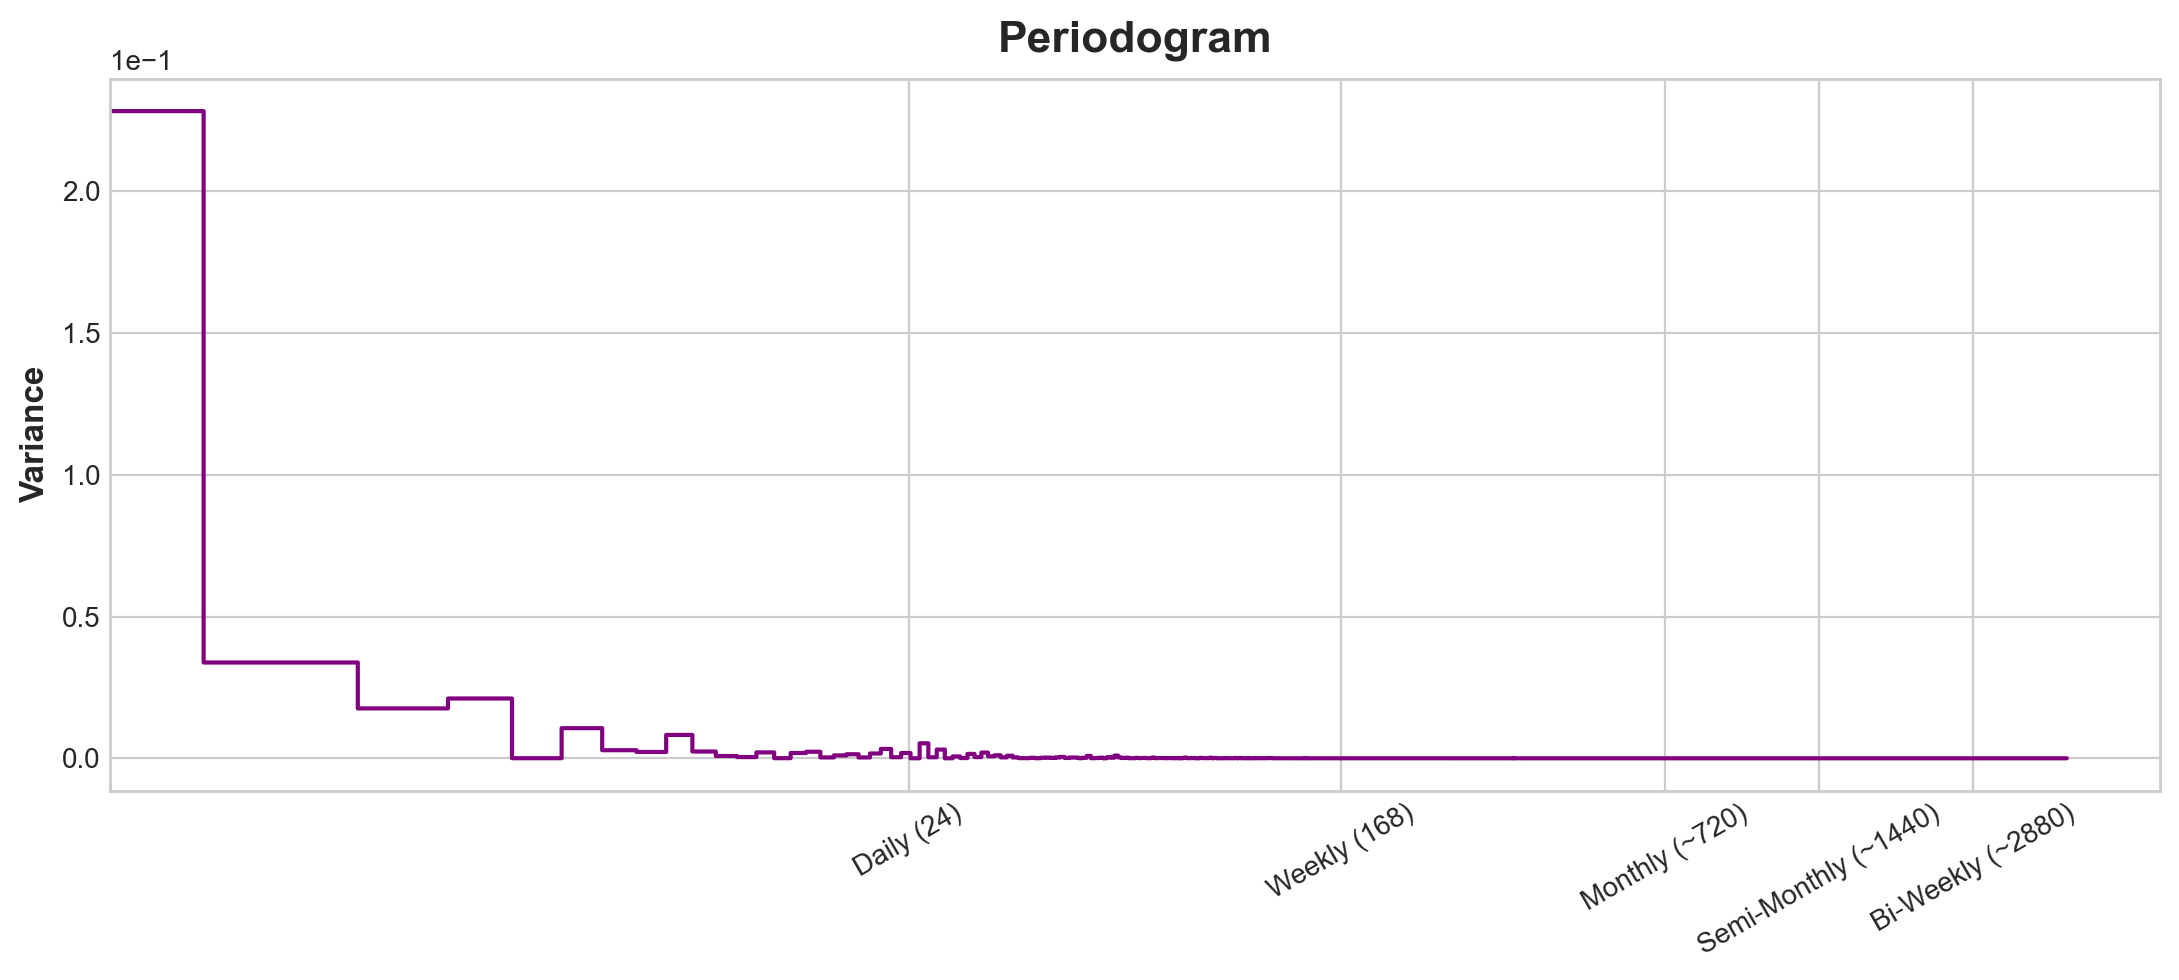

In [394]:
seasonal_df = ancillary_df[["Hours", "Hydrometric level", "Variation"]].copy()

seasonal_df.dropna(inplace=True)

plot_periodogram(seasonal_df["Variation"])
plot_periodogram(seasonal_df["Hydrometric level"])

### Sentinel-2

Multispectral data in the period of interest.

The list of bands [[Source]](https://hatarilabs.com/ih-en/how-many-spectral-bands-have-the-sentinel-2-images):

| Bands                         | Central Wavelength (µm) | Resolution (m) |
| ----------------------------- | ----------------------- | -------------- |
| Band 1 - Coastal aerosol      | 0.443                   | 60             |
| Band 2 - Blue                 | 0.490                   | 10             |
| Band 3 - Green                | 0.560                   | 10             |
| Band 4 - Red                  | 0.665                   | 10             |
| Band 5 - Vegetation Red Edge  | 0.705                   | 20             |
| Band 6 - Vegetation Red Edge  | 0.740                   | 20             |
| Band 7 - Vegetation Red Edge  | 0.783                   | 20             |
| Band 8 - NIR                  | 0.842                   | 10             |
| Band 8A - Vegetation Red Edge | 0.865                   | 20             |
| Band 9 - Water vapour         | 0.945                   | 60             |
| Band 10 - SWIR - Cirrus       | 1.375                   | 60             |
| Band 11 - SWIR                | 1.610                   | 20             |
| Band 12 - SWIR                | 2.190                   | 20             |

Filenames [Source](https://sentinels.copernicus.eu/web/sentinel/user-guides/sentinel-2-msi/naming-convention):

`S2A_MSIL2A_20220309T100841_N0400_R02` means:

- "S2A": satellite used to capture the data (Sentinel-2A)
- "MSIL2A": denotes the Level-2A product level (atmospherically corrected Surface Reflectance (SR) images)
- "20220309T100841": the datatake sensing start time (March 9, 2022, at 10:08:41 UTC)
- "N0400": the Processing Baseline number
- "R02": Relative Orbit number (R001 - R143)

The images span from about 2022.03.07. to 2022.08.24.

The ancillary data spans from 2022.01.12. 01:00:00 to 2023.01.12. 18:00:00 (an entry every hour).


In [89]:
# meta info seems to be useless
sentinel_2_meta_path = (
    "/kaggle/input/sentinel-2-cremona/sentinel-2-cremona/S2_Cremona_DESCENDING_info.csv"
)

sentinel_2_meta_df = pd.read_csv(sentinel_2_meta_path)
sentinel_2_meta_df.head()

,system:index,.geo
0,20220307T101759_20220307T102247_T32TNR,"{""type"":""MultiPoint"",""coordinates"":[]}"
1,20220307T101759_20220307T102247_T32TNQ,"{""type"":""MultiPoint"",""coordinates"":[]}"
2,20220309T100841_20220309T101722_T32TNR,"{""type"":""MultiPoint"",""coordinates"":[]}"
3,20220309T100841_20220309T101722_T32TNQ,"{""type"":""MultiPoint"",""coordinates"":[]}"
4,20220322T101711_20220322T102531_T32TNR,"{""type"":""MultiPoint"",""coordinates"":[]}"


In [133]:
import os
import rasterio
from typing import List, Tuple
import matplotlib.pyplot as plt

from torch.utils.data import Dataset
import numpy as np

from torchvision.transforms import Compose, ToTensor


class S2(Dataset):
    def __init__(
        self,
        root: str = "/kaggle/input/sentinel-2-cremona/sentinel-2-cremona",
        transform: Compose = Compose([ToTensor()]),
    ):
        self.root = os.path.join(root, "images")
        self.transform = transform
        self.files = self.load_files(self.root)
        self.bands = self.get_bands()
        self.readable_band_names = {
            "B2": "B2 - Blue",
            "B3": "B3 - Green",
            "B4": "B4 - Red",
            "B5": "B5 - Red Edge 1",
            "B6": "B6 - Red Edge 2",
            "B7": "B7 - Red Edge 3",
            "B8A": "B8A - NIR Narrow",
            "B8": "B8 - NIR Wide",
            "B11": "B11 - SWIR 1",
            "B12": "B12 - SWIR 2",
        }

    @staticmethod
    def load_files(root: str) -> List[str]:
        return os.listdir(root)

    def __len__(self) -> int:
        return len(self.files)

    def __getitem__(self, idx: int) -> torch.Tensor:
        file = self.files[idx]
        with rasterio.open(os.path.join(self.root, file)) as data:
            img = data.read()
            img = img.transpose(1, 2, 0)  # CHW
        x = self.transform(img)
        return x

    def get_bands(self) -> Tuple[str]:
        file = self.files[0]
        with rasterio.open(os.path.join(self.root, file)) as data:
            return data.descriptions

    def get_band_index(self, band_name):
        return self.bands.index(band_name)

    def plot_image(self, idx, band_name) -> None:
        colormap = None

        if band_name in ["B2", "B3", "B4"]:
            colormap = "viridis"
        elif band_name in ["B5", "B6", "B7"]:
            colormap = "pink"
        elif band_name in ["B8A", "B8"]:
            colormap = "gray"
        elif band_name in ["B11", "B12"]:
            colormap = "hot"

        band_idx = self.bands.index(band_name)

        img = self[idx]
        band = img[band_idx, :, :]

        plt.imshow(band, cmap=colormap)
        plt.axis("off")
        plt.title(f"{self.readable_band_names[band_name]}")
        plt.show()

In [134]:
dataset = S2()

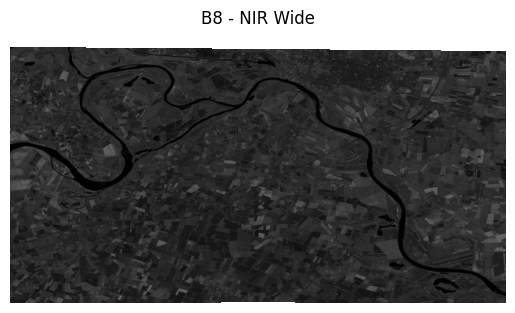

In [139]:
dataset.plot_image(0, "B8")

## Task 1

To extract the water extents as accurately as possible by classifying the data or by using water-related indexes.


## Task 2

To compute the total water surface extents statistics (histogram, mean, variance, max and min values) in the period of interest.


## Task 3

To find possible correlations between the measurements extracted from EO data and those on the ground.


## Task 4

To build a regression model for the water extent and/or water level measures for nowcasting purposes (i.e., forecasting at a very close time value).


For this task, we will perform supervised learning on the ancillary dataset containing hydrometric level measurements. We will investigate the following models:

- It is considered best practice to start with a persistence model in time series forecasting, which is a very naive model that predicts the next value to be the same as the current value. This is a good baseline to compare other models to.
- Next, we will try to improve on the persistence model by using a simple linear auto-regressive model...
- Finally, we will experiment with adding image features extracted from the period of interest and predicting the hydrometric level. (also check performance based on solely the image features) -> point is: with data fusion, we can improve the performance even further

Given the good performance of these simple models, it is not
maybe try an LSTM?


## Data analysis


In [63]:
ancillary_df["Hydrometric level"].describe()

count    8700.000000
mean       -7.309478
std         0.637510
min        -8.590000
25%        -7.770000
50%        -7.280000
75%        -6.850000
max        -5.670000
Name: Hydrometric level, dtype: float64

<AxesSubplot: >

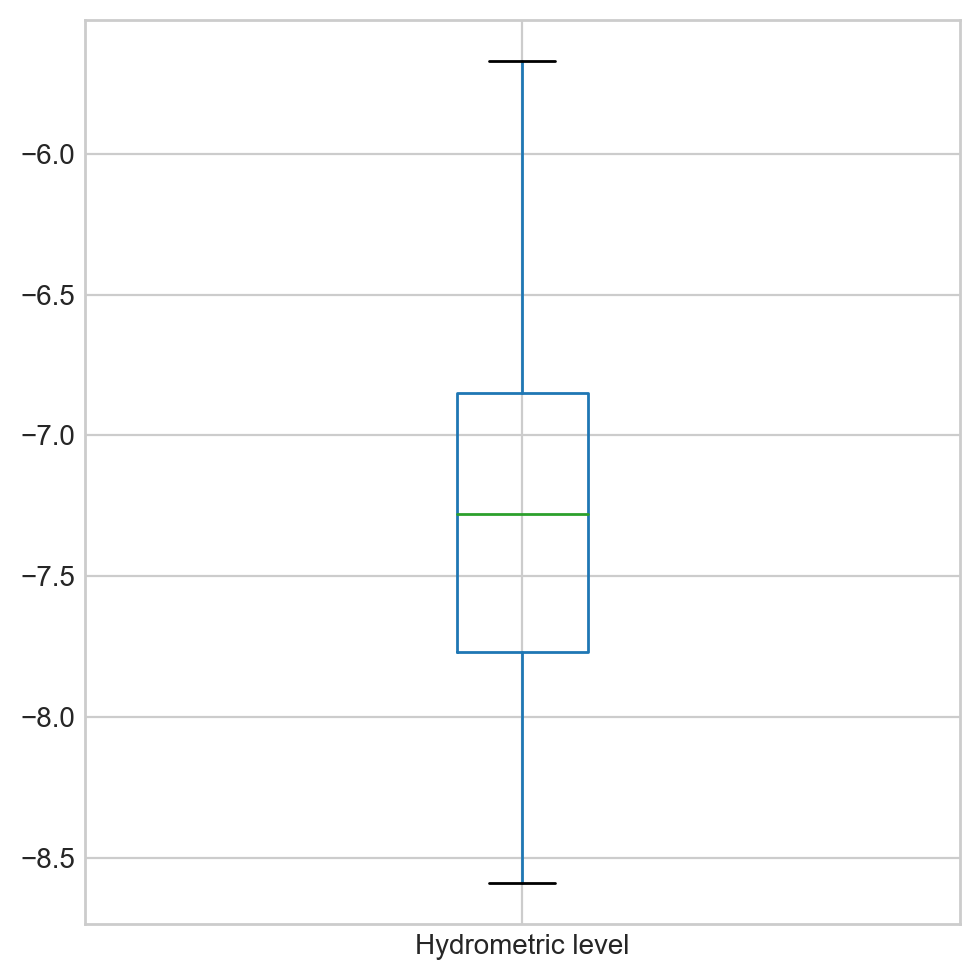

In [698]:
# create boxplot for hydrometric level

ancillary_df.boxplot(column=["Hydrometric level"], figsize=(5, 5))

<AxesSubplot: >

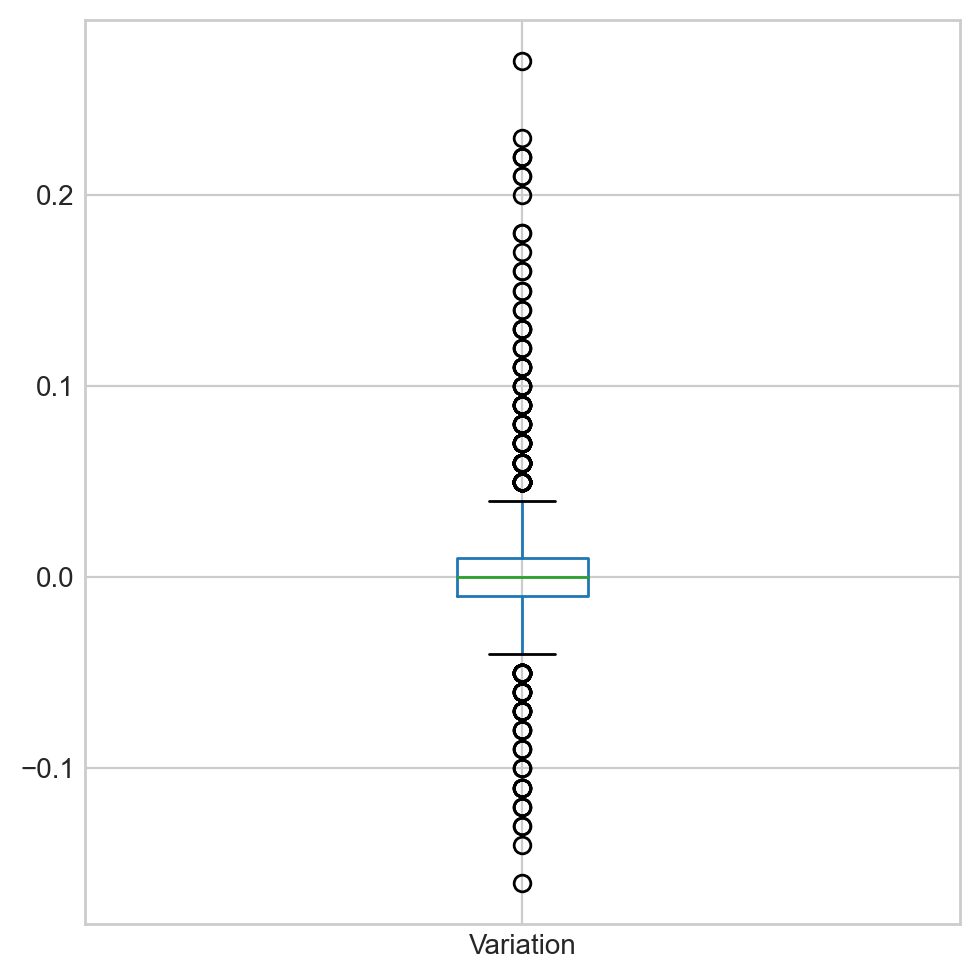

In [697]:
ancillary_df.boxplot(column=["Variation"], figsize=(5, 5))

In [64]:
ancillary_df["Variation"].describe()

count    8687.000000
mean       -0.000024
std         0.018291
min        -0.160000
25%        -0.010000
50%         0.000000
75%         0.010000
max         0.270000
Name: Variation, dtype: float64

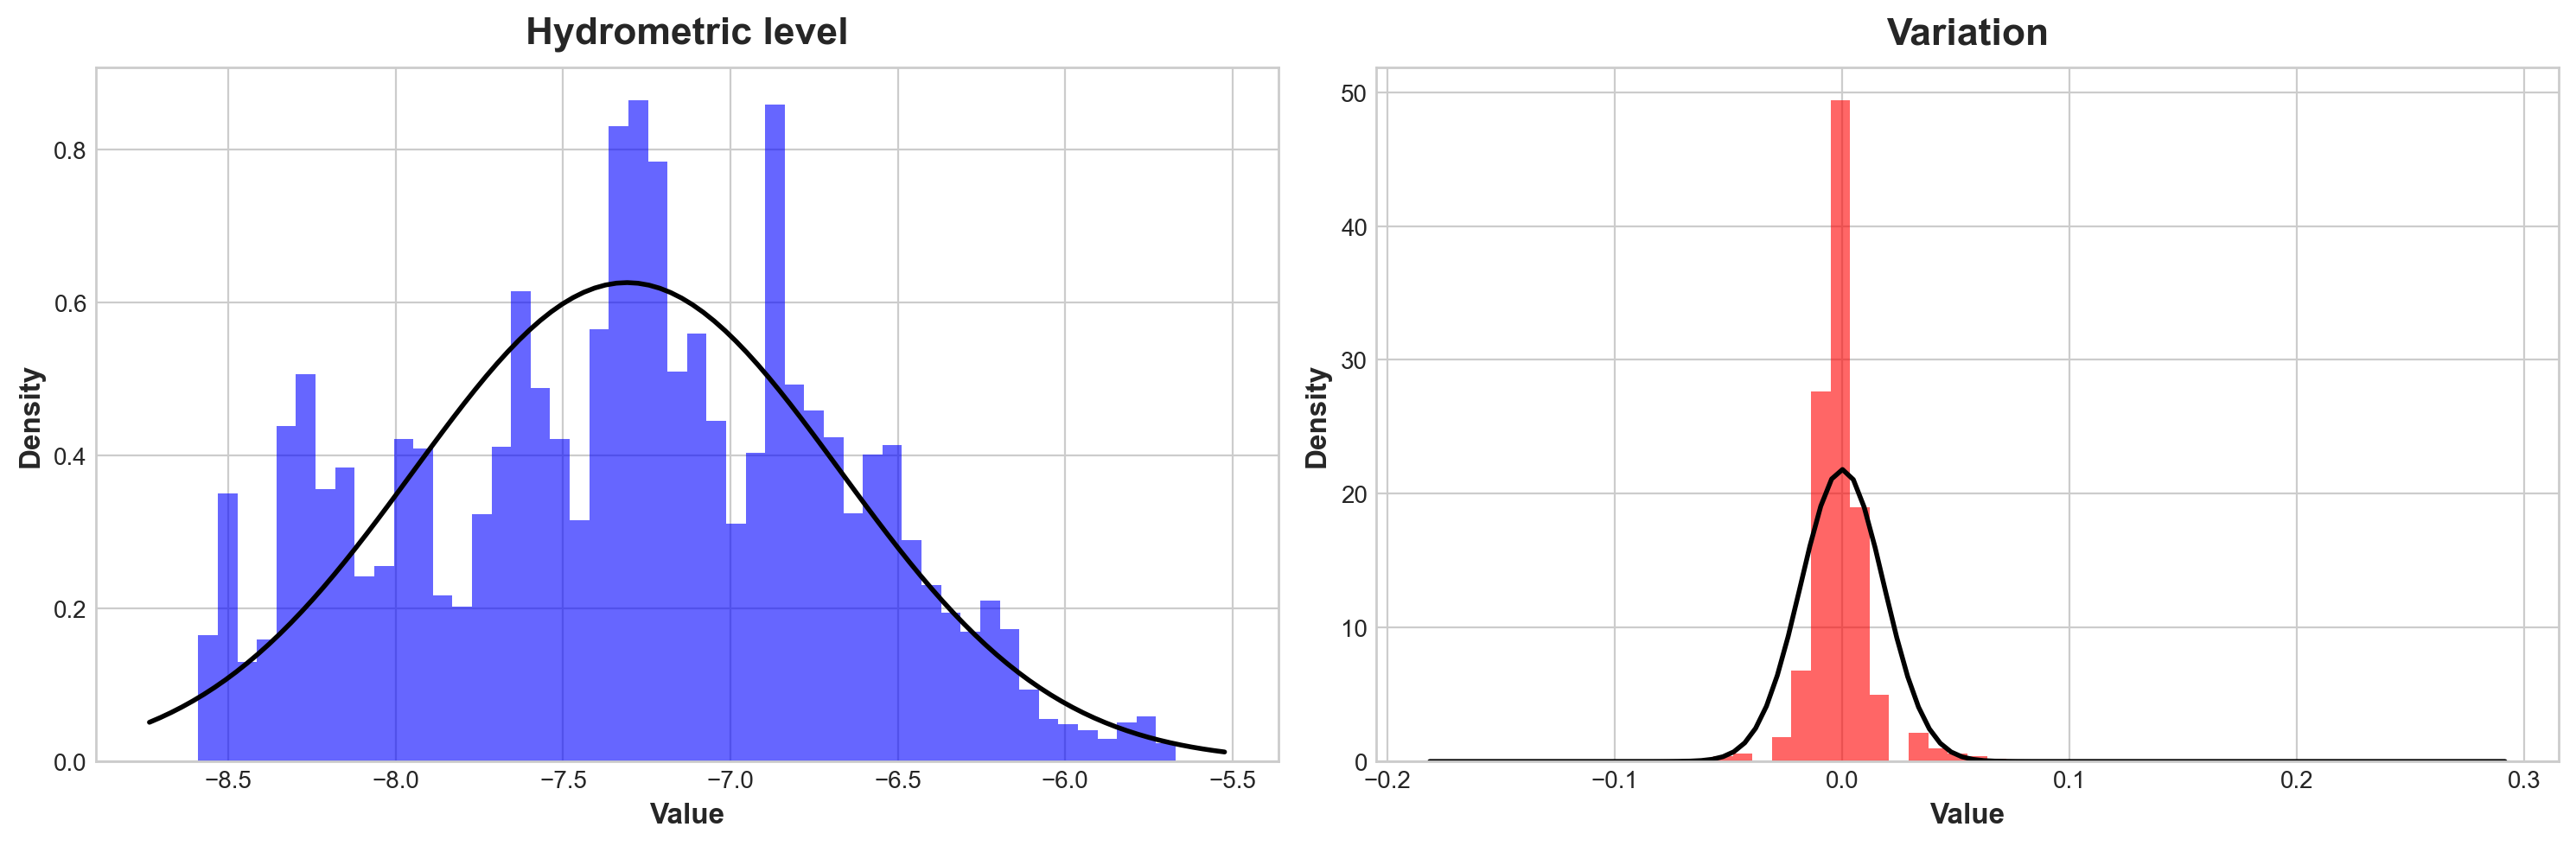

In [399]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

fig, axs = plt.subplots(1, 2, figsize=(15, 5))  # 1 row, 2 columns

# First subplot for "Hydrometric level"
mu1, std1 = (
    ancillary_df["Hydrometric level"].mean(),
    ancillary_df["Hydrometric level"].std(),
)  # mean and standard deviation
axs[0].hist(
    ancillary_df["Hydrometric level"], bins=50, density=True, color="b", alpha=0.6
)
xmin, xmax = axs[0].get_xlim()
x1 = np.linspace(xmin, xmax, 100)
p1 = norm.pdf(x1, mu1, std1)
axs[0].plot(x1, p1, "k", linewidth=2)
axs[0].set_title("Hydrometric level")
axs[0].set_xlabel("Value")
axs[0].set_ylabel("Density")

# Second subplot for "Variation"
mu2, std2 = (
    ancillary_df["Variation"].mean(),
    ancillary_df["Variation"].std(),
)  # mean and standard deviation
axs[1].hist(ancillary_df["Variation"], bins=50, density=True, color="r", alpha=0.6)
xmin, xmax = axs[1].get_xlim()
x2 = np.linspace(xmin, xmax, 100)
p2 = norm.pdf(x2, mu2, std2)
axs[1].plot(x2, p2, "k", linewidth=2)
axs[1].set_title("Variation")
axs[1].set_xlabel("Value")
axs[1].set_ylabel("Density")

plt.tight_layout()  # Adjusts subplot params so that the subplot(s) fits into the figure area.
plt.show()

From the basic statistics we can see that the data is more or less normally distributed, and the variation is very low. We can see that the mean is very close to zero, and the standard deviation of the values is ~0.02 meaning that most of the time small changes happened to the water level (between hours). Furthermore, 75% of the values are less than or equal to 0.01.

Intuitively, this means that the water level does not change much per hour (usually less than 1 centimeter), with the greatest change being 0.027 meters, which is 2.7 centimeters.

Let us take a look at daily and monthly statistics and investigate the changes in mean and variance over time.


In [96]:
resample_df = ancillary_df.copy()

resample_df.index = pd.to_datetime(resample_df["Hours"])

# Resample to daily and calculate the mean
daily_df_mean = resample_df.resample("D").mean()
daily_df_variance = resample_df.resample("D").var()

# Resample to monthly and calculate the mean
monthly_df_mean = resample_df.resample("M").mean()
monthly_df_variance = resample_df.resample("M").var()

/var/folders/jt/3dr_0yh91s15rcc43pkynyqr0000gn/T/ipykernel_83787/3301080812.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  daily_df_mean = resample_df.resample('D').mean()
/var/folders/jt/3dr_0yh91s15rcc43pkynyqr0000gn/T/ipykernel_83787/3301080812.py:9: FutureWarning: The default value of numeric_only in DataFrameGroupBy.var is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  daily_df_variance = resample_df.resample('D').var()
/var/folders/jt/3dr_0yh91s15rcc43pkynyqr0000gn/T/ipykernel_83787/3301080812.py:12: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only o

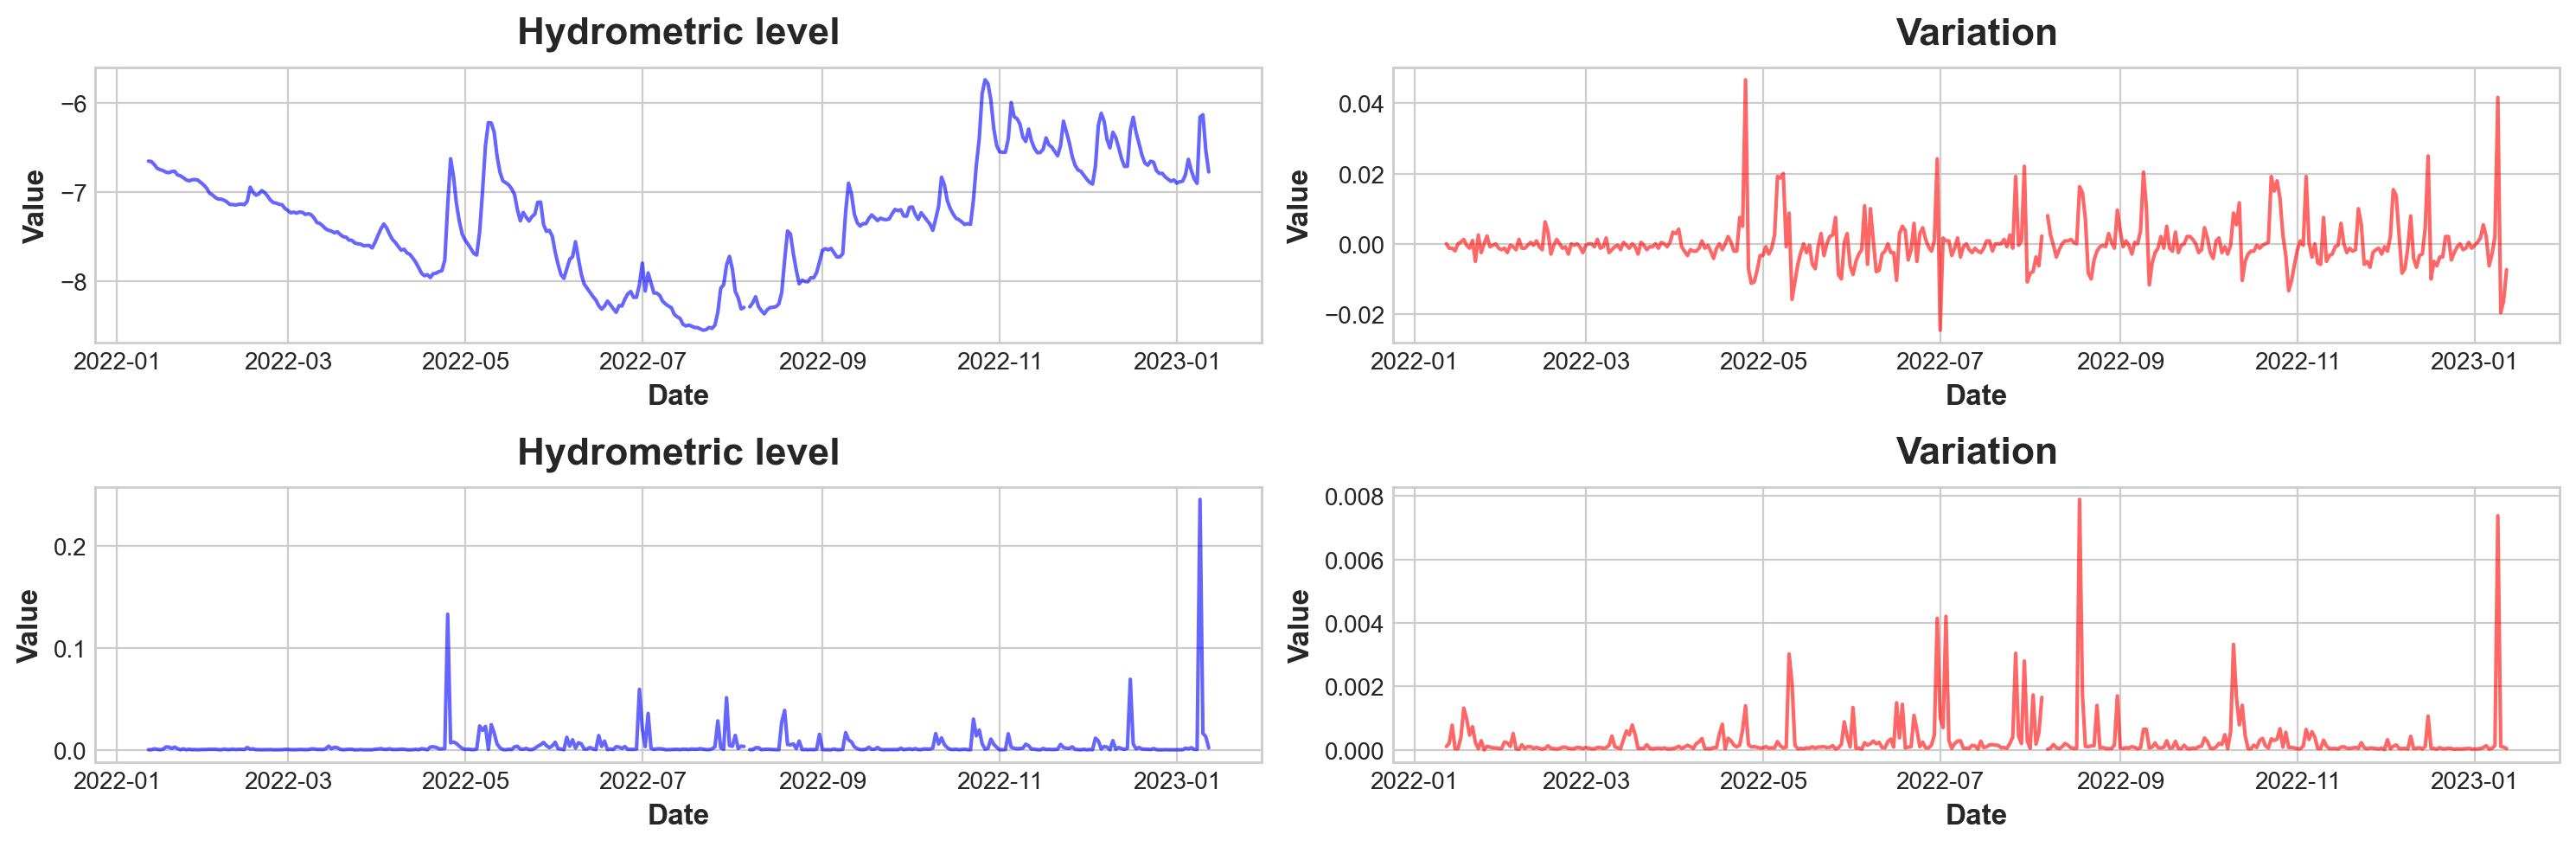

In [400]:
# plot changes in mean and variance for daily data

fig, axs = plt.subplots(2, 2, figsize=(15, 5))

axs[0, 0].plot(daily_df_mean["Hydrometric level"], color="b", alpha=0.6)
axs[0, 0].set_title("Hydrometric level")
axs[0, 0].set_xlabel("Date")
axs[0, 0].set_ylabel("Value")

axs[0, 1].plot(daily_df_mean["Variation"], color="r", alpha=0.6)
axs[0, 1].set_title("Variation")
axs[0, 1].set_xlabel("Date")
axs[0, 1].set_ylabel("Value")

axs[1, 0].plot(daily_df_variance["Hydrometric level"], color="b", alpha=0.6)
axs[1, 0].set_title("Hydrometric level")
axs[1, 0].set_xlabel("Date")
axs[1, 0].set_ylabel("Value")

axs[1, 1].plot(daily_df_variance["Variation"], color="r", alpha=0.6)
axs[1, 1].set_title("Variation")
axs[1, 1].set_xlabel("Date")
axs[1, 1].set_ylabel("Value")

plt.tight_layout()
plt.show()

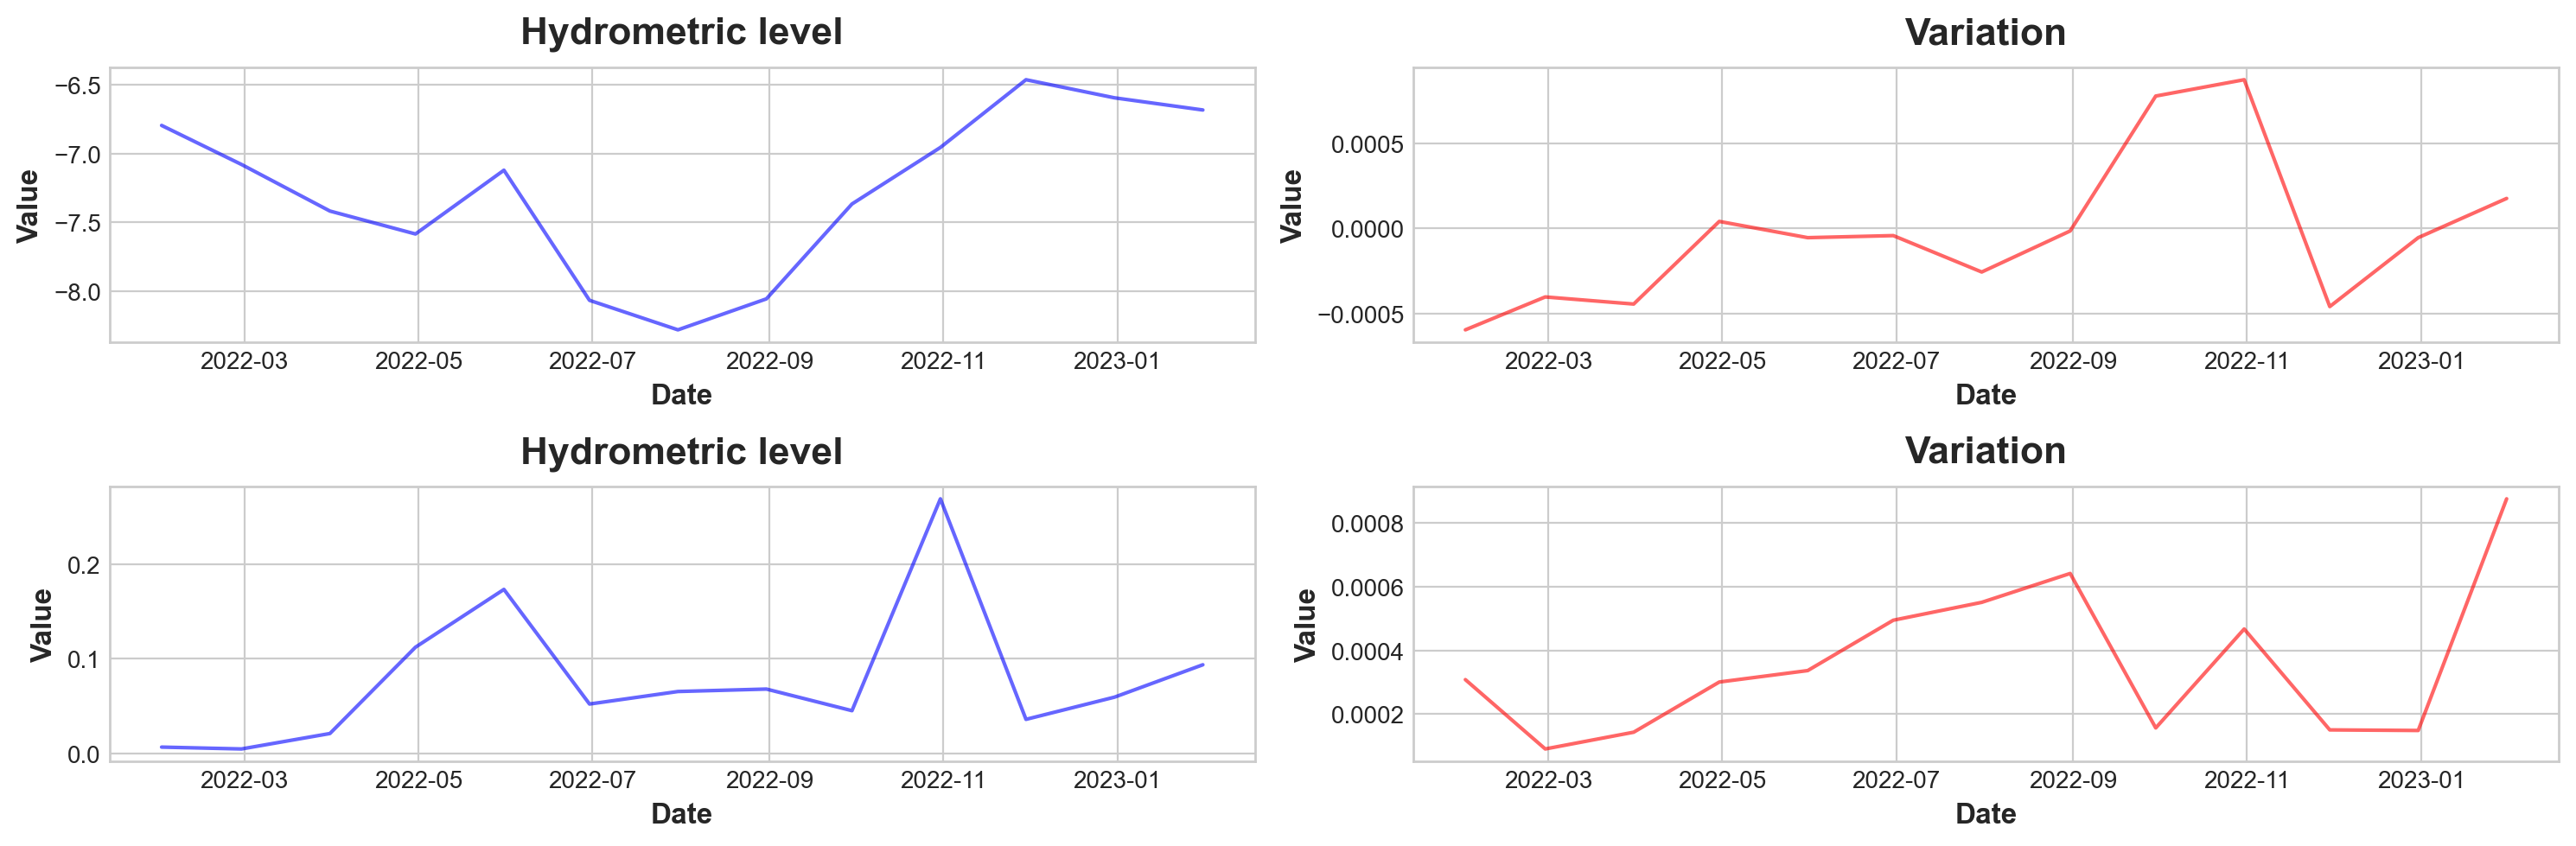

In [401]:
# plot changes in mean and variance for monthly data

fig, axs = plt.subplots(2, 2, figsize=(15, 5))

axs[0, 0].plot(monthly_df_mean["Hydrometric level"], color="b", alpha=0.6)
axs[0, 0].set_title("Hydrometric level")
axs[0, 0].set_xlabel("Date")
axs[0, 0].set_ylabel("Value")

axs[0, 1].plot(monthly_df_mean["Variation"], color="r", alpha=0.6)
axs[0, 1].set_title("Variation")
axs[0, 1].set_xlabel("Date")
axs[0, 1].set_ylabel("Value")

axs[1, 0].plot(monthly_df_variance["Hydrometric level"], color="b", alpha=0.6)
axs[1, 0].set_title("Hydrometric level")
axs[1, 0].set_xlabel("Date")
axs[1, 0].set_ylabel("Value")

axs[1, 1].plot(monthly_df_variance["Variation"], color="r", alpha=0.6)
axs[1, 1].set_title("Variation")
axs[1, 1].set_xlabel("Date")
axs[1, 1].set_ylabel("Value")

plt.tight_layout()
plt.show()

We can see however, that the mean and variance changed over time...

Seasonal decomposition: we investigate daily and monthly trends


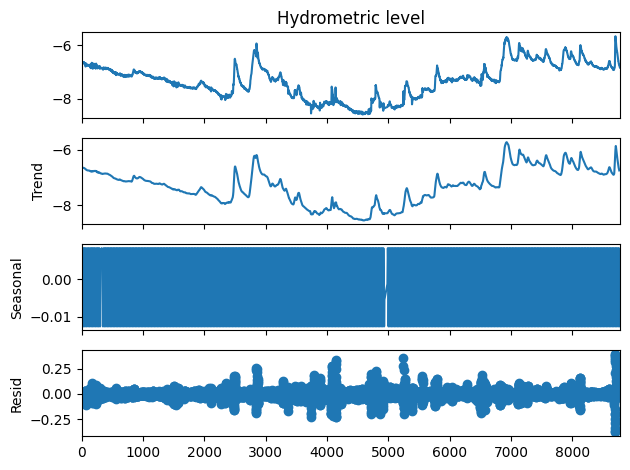

In [101]:
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

sd_df = ancillary_df.copy()

series = sd_df["Hydrometric level"].dropna()

result = seasonal_decompose(
    series, model="additive", period=24
)  # daily seasonality? period=24

result.plot()
plt.show()

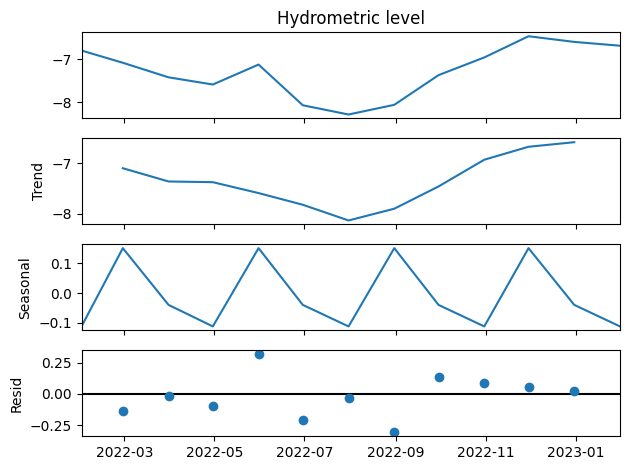

In [103]:
series = monthly_df_mean["Hydrometric level"]

result = seasonal_decompose(
    series, model="additive", period=3
)  # quarter year seasonality?

result.plot()
plt.show()

Let us investigate the periodicity in the data.


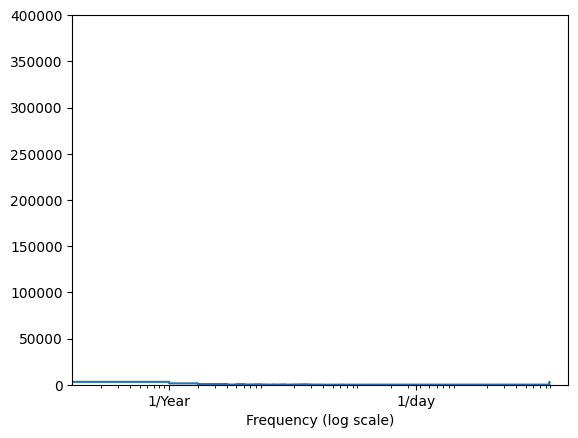

In [83]:
import torch
import numpy as np
import matplotlib.pyplot as plt

hydro_data = ancillary_df["Hydrometric level"].dropna().values

hydro_lvl = torch.from_numpy(hydro_data)

fft = torch.fft.fft(hydro_lvl)
fft_abs = np.abs(fft.numpy())
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(hydro_data)
hours_per_year = 24 * 365.2524
years_per_dataset = n_samples_h / (hours_per_year)

f_per_year = f_per_dataset / years_per_dataset
plt.step(f_per_year, fft_abs)
plt.xscale("log")
plt.ylim(0, 400000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 365.2524], labels=["1/Year", "1/day"])
_ = plt.xlabel("Frequency (log scale)")

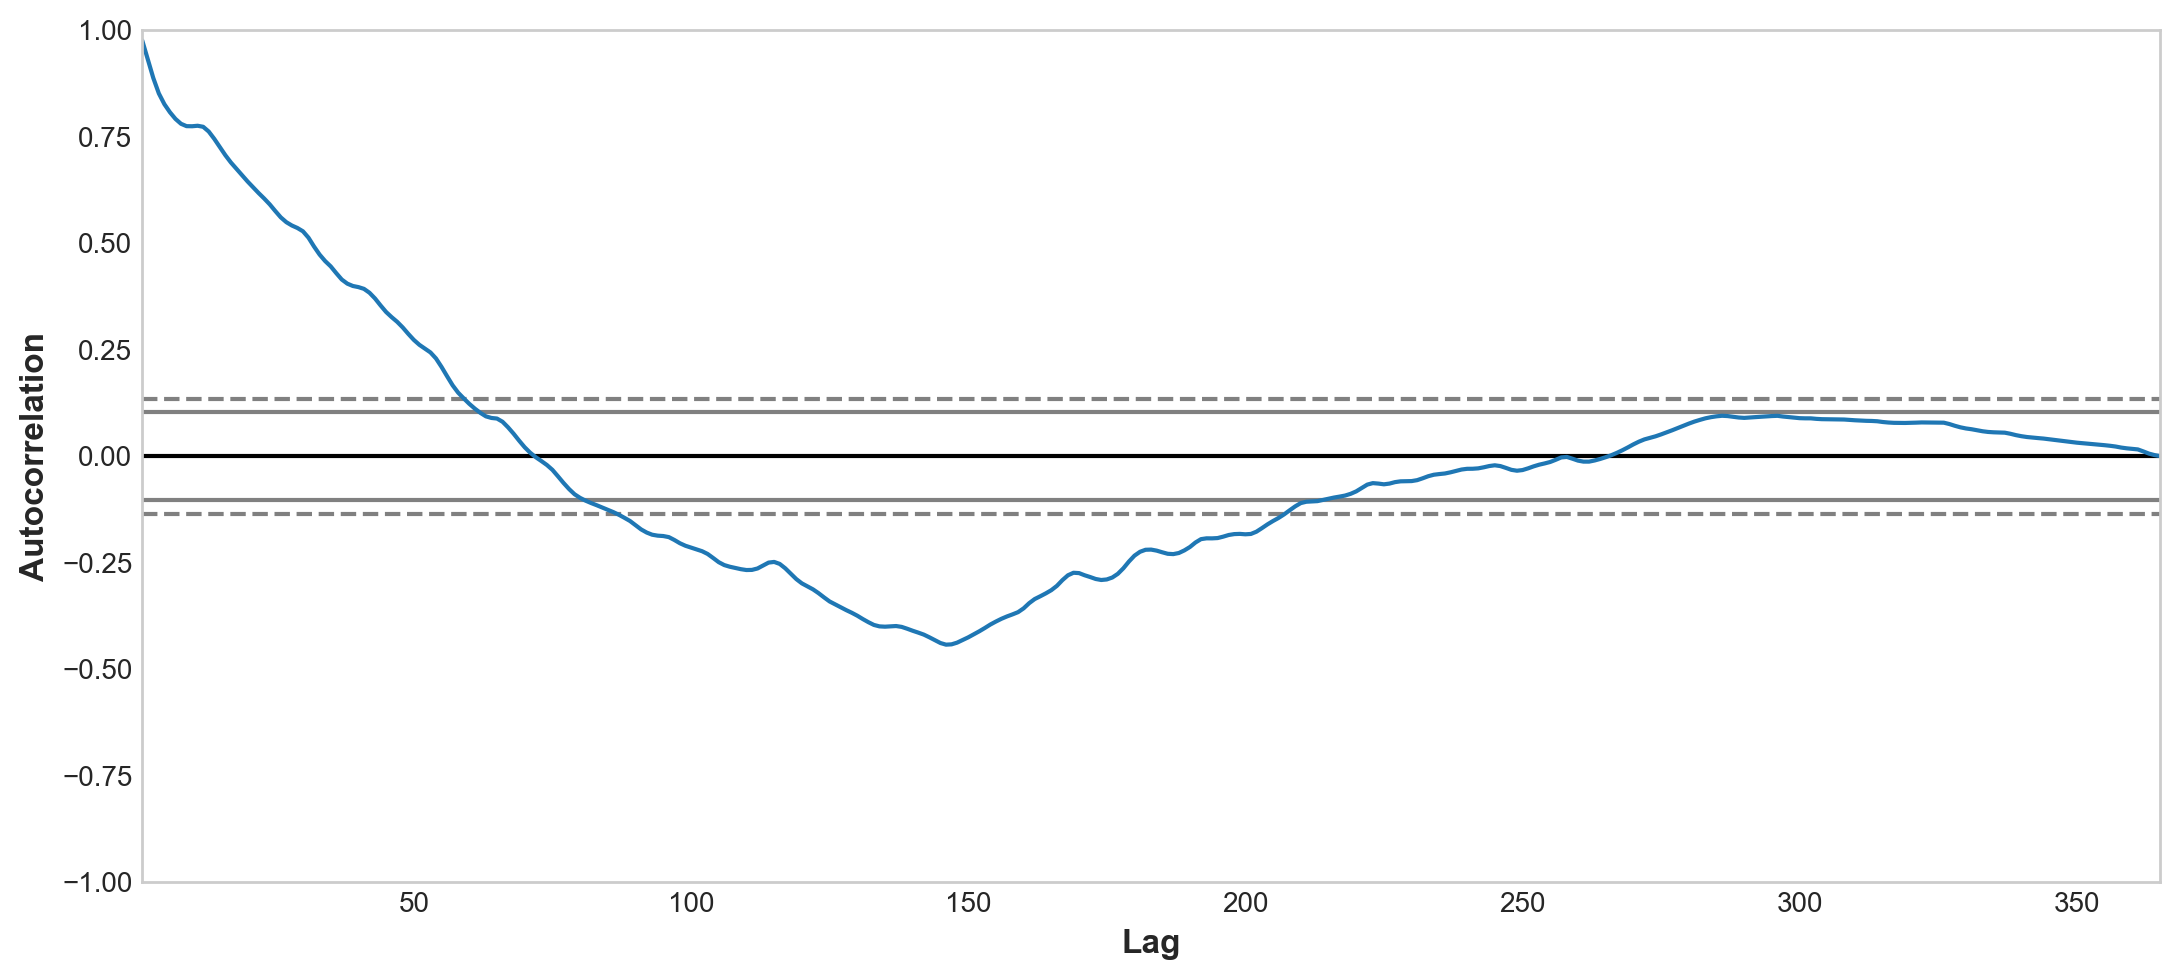

In [402]:
from pandas.plotting import autocorrelation_plot, lag_plot

# autocorrelation_plot(hydro_data) # hourly
autocorrelation_plot(daily_df_mean["Hydrometric level"].dropna().values)  # daily
# autocorrelation_plot(monthly_df_mean["Hydrometric level"].dropna().values) # monthly

plt.show()

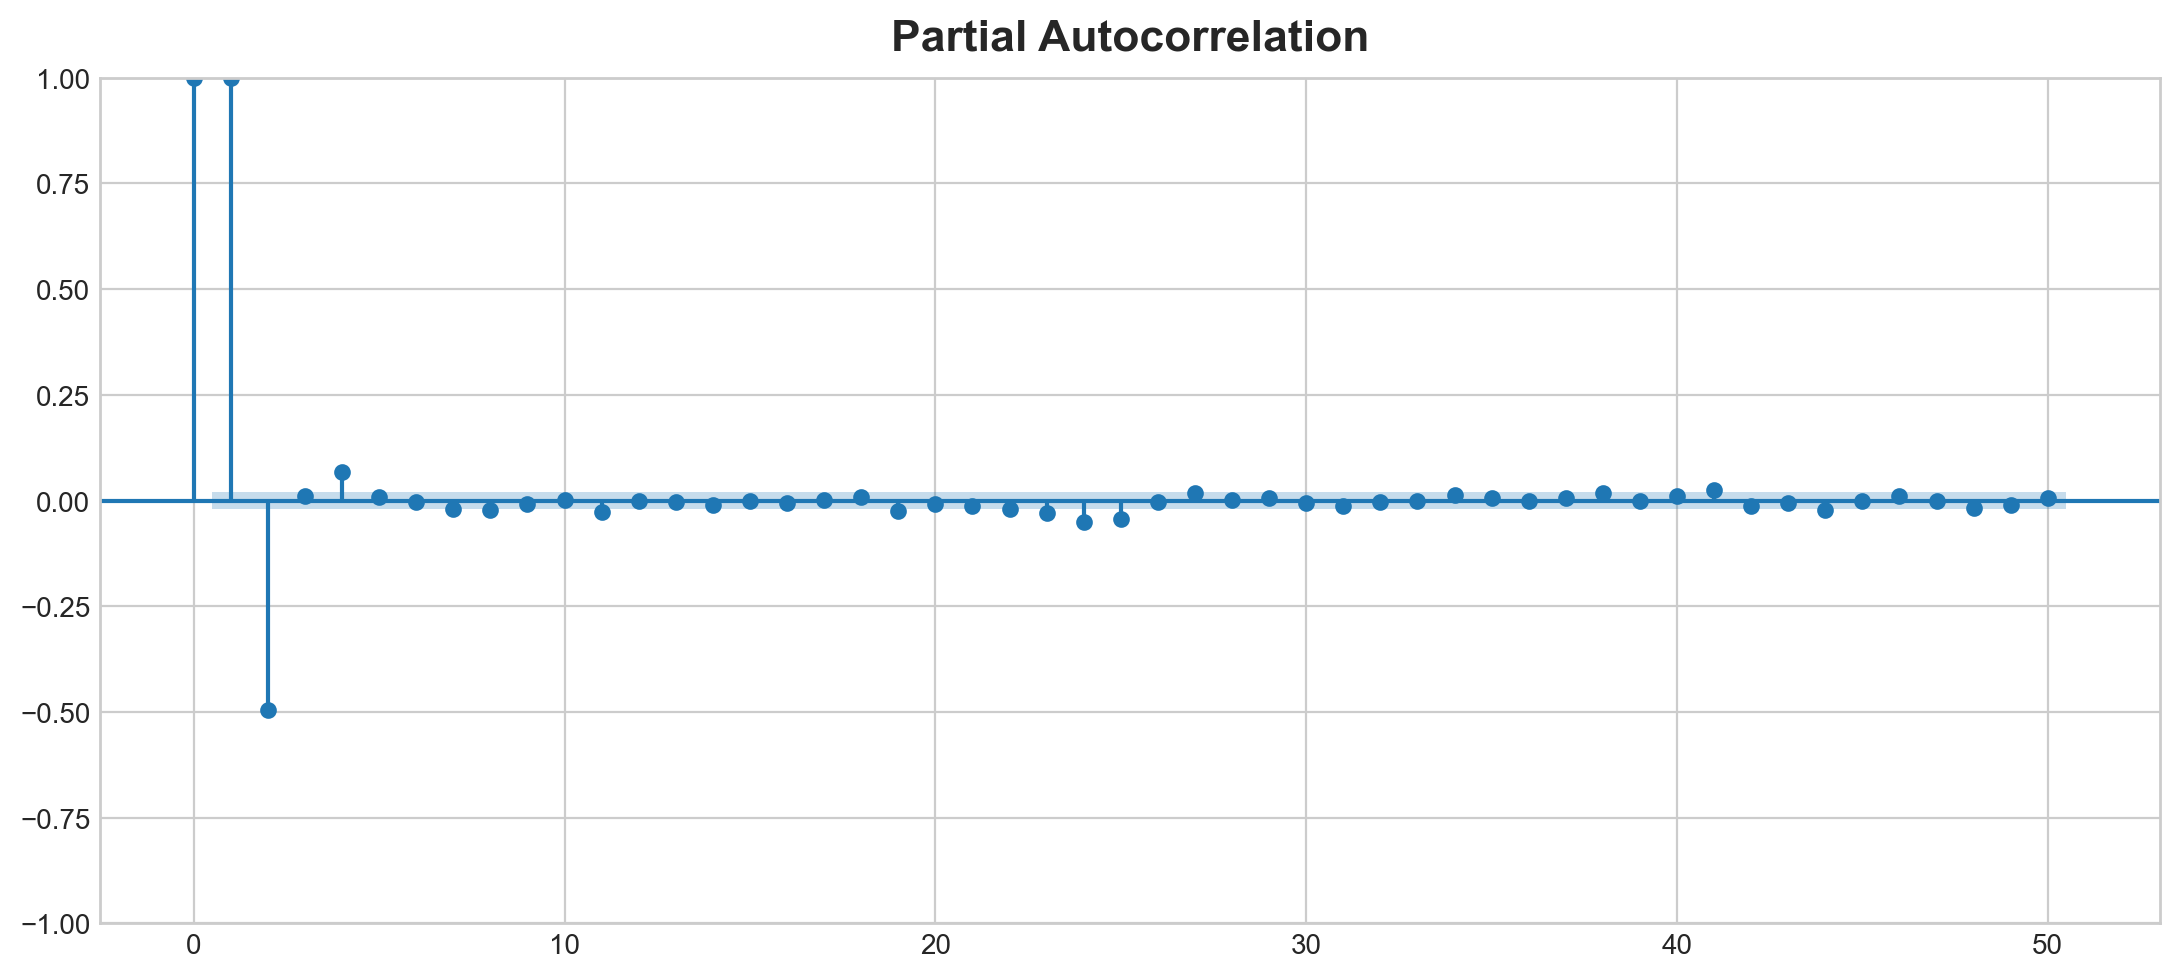

In [403]:
from statsmodels.graphics.tsaplots import plot_pacf

plot_pacf(hydro_data, lags=50)
pyplot.show()

<AxesSubplot: xlabel='y(t)', ylabel='y(t + 2)'>

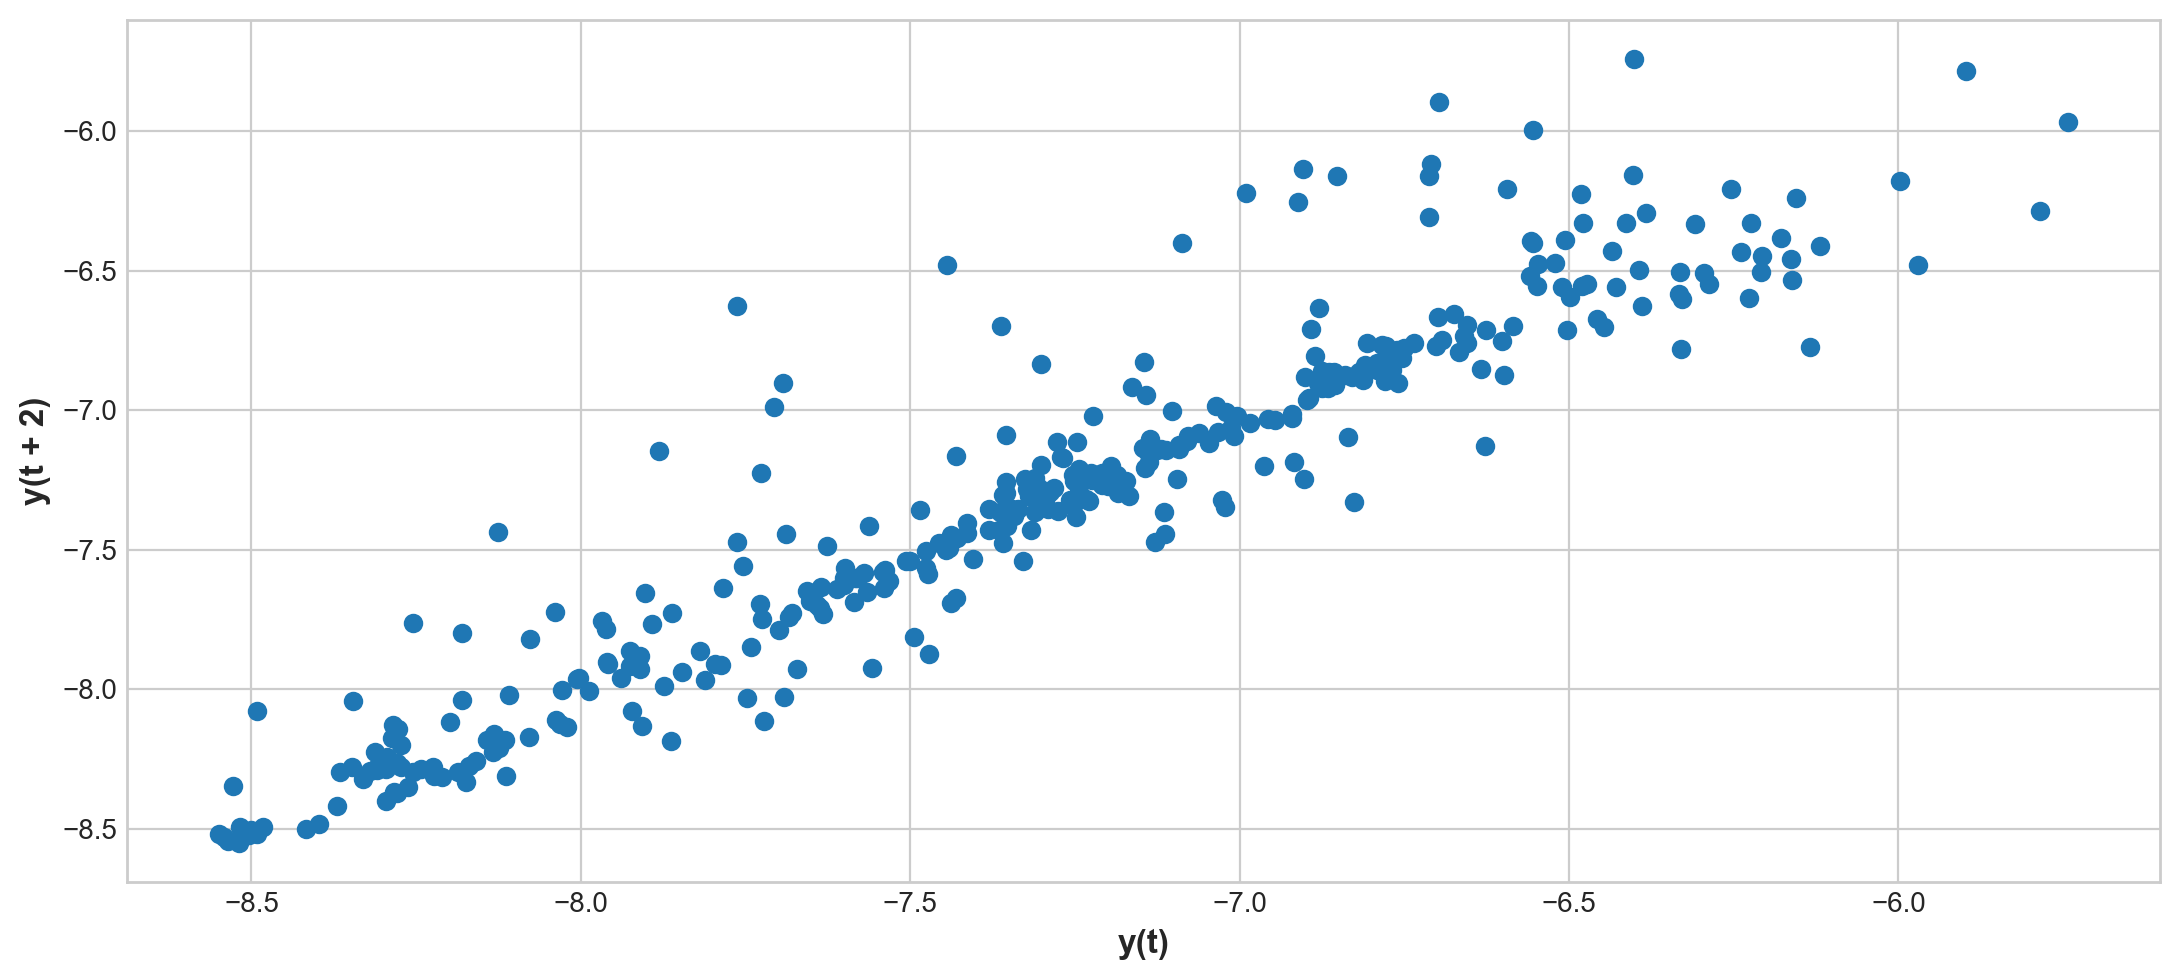

In [404]:
lag_plot(daily_df_mean["Hydrometric level"].dropna(), lag=2)

We can see that there is a very strong autocorrelation at the lag of about 1 day and this decreases over time. This means that the water level is very similar from one day to the next, but the similarity decreases over time.


## Persistence model


          t-1         t
0         NaN -6.654348
1   -6.654348 -6.659583
2   -6.659583 -6.693333
3   -6.693333 -6.735455
4   -6.735455 -6.750000
..        ...       ...
361 -6.852917 -6.903333
362 -6.903333 -6.161250
363 -6.161250 -6.135000
364 -6.135000 -6.533333
365 -6.533333 -6.775263

[366 rows x 2 columns]
Test MSE: 0.025
Test RMSE: 0.159
Test MAE: 0.106


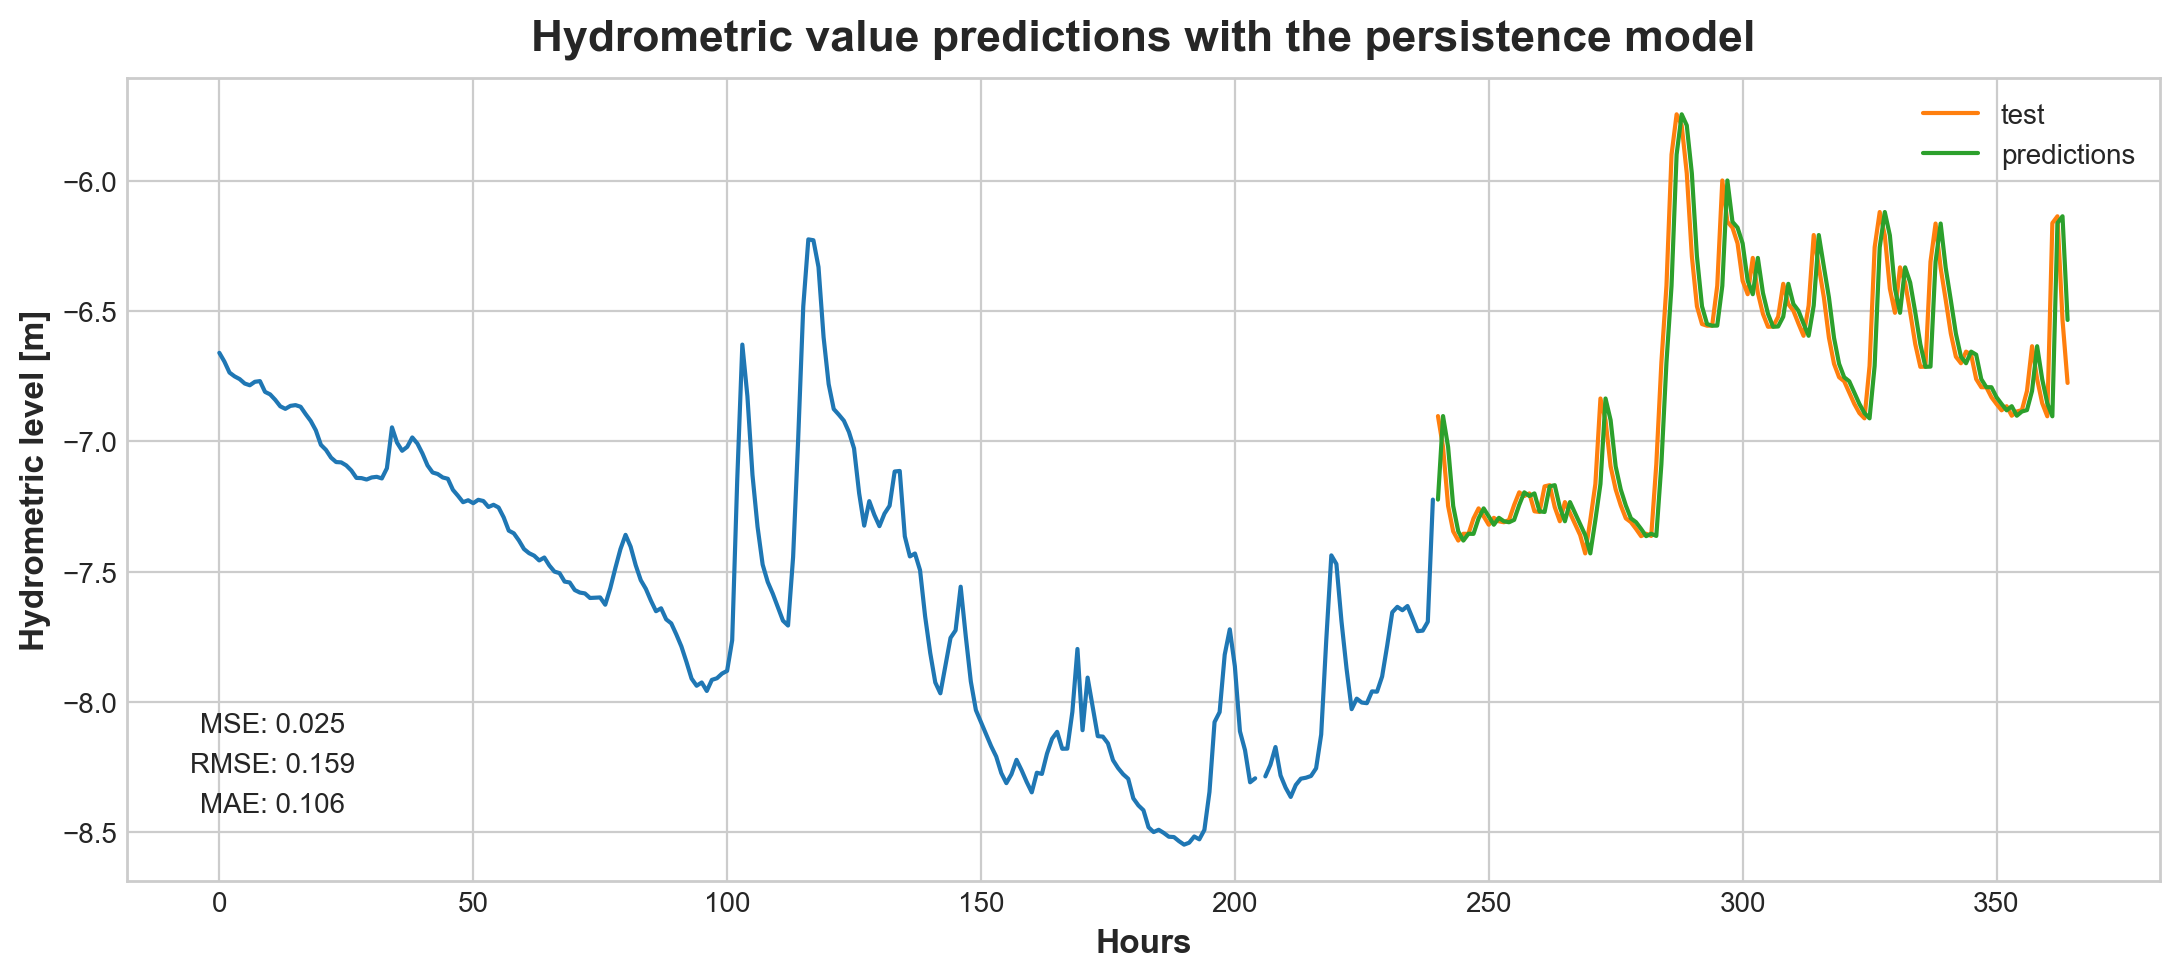

In [715]:
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error
from matplotlib import pyplot

series = daily_df_mean["Hydrometric level"]

values = pd.DataFrame(series.values)
df = pd.concat([values.shift(1), values], axis=1)
df.columns = ["t-1", "t"]
print(df)

# split into train and test sets
X = df.values
train_size = int(len(X) * 0.66)
train, test = X[1:train_size], X[train_size:]
train_X, train_y = train[:, 0], train[:, 1]
test_X, test_y = test[:, 0], test[:, 1]


# persistence model
def model_persistence(x):
    return x


# walk-forward validation
predictions = list()
for x in test_X:
    y_hat = model_persistence(x)
    predictions.append(y_hat)
rmse_test_score = mean_squared_error(test_y, predictions, squared=False)  # RMSE
mse_test_score = mean_squared_error(test_y, predictions)  # MSE
mae_test_score = mean_absolute_error(test_y, predictions)  # MAE
print("Test MSE: %.3f" % mse_test_score)
print("Test RMSE: %.3f" % rmse_test_score)
print("Test MAE: %.3f" % mae_test_score)

pyplot.plot(train_y)
pyplot.plot([None for i in train_y] + [x for x in test_y], label="test")
pyplot.plot([None for i in train_y] + [x for x in predictions], label="predictions")
pyplot.title("Hydrometric value predictions with the persistence model")
plt.ylabel("Hydrometric level [m]")
plt.legend()
# plt.xlim(6000, 6024)
# plt.ylim(-7.0, -7.5)

# add errors to the plot

plt.text(
    0.5,
    0.5,
    "MSE: %.3f" % mse_test_score,
    horizontalalignment="center",
    verticalalignment="center",
    transform=ax.transAxes,
)

plt.text(
    0.5,
    0.4,
    "RMSE: %.3f" % rmse_test_score,
    horizontalalignment="center",
    verticalalignment="center",
    transform=ax.transAxes,
)

plt.text(
    0.5,
    0.3,
    "MAE: %.3f" % mae_test_score,
    horizontalalignment="center",
    verticalalignment="center",
    transform=ax.transAxes,
)


plt.xlabel("Hours")
pyplot.show()

In [702]:
mse_test_score, rmse_test_score, mae_test_score

(0.00029424314256688123, 0.017153516915399045, 0.008787673552319674)

We set the baseline model to be a persistence model, which predicts the next value to be the same as the current one. We can see that because of the high autocorrelation in the data, this model performs quite well. However, other trends could exist in the data that are not captured by this model.


## Improvements


In [500]:
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression

# create datasets
X, y = make_regression(
    n_samples=1000,
    n_features=2,
    n_informative=5,
    n_targets=2,
    random_state=1,
    noise=0.5,
)
pd.DataFrame(X).head()

,0,1
0,-0.530120,-0.407240
1,0.755392,0.700982
2,0.459782,-0.206331
3,1.594465,-0.895442
4,1.312895,0.023357


In [678]:
import numpy as np


def create_multistep_df(steps_to_predict):
    multistep_df = ancillary_df.dropna().copy()

    for i in range(1, steps_to_predict + 1):
        multistep_df[f"Hydrometric_lvl_shift_{i}"] = multistep_df[
            "Hydrometric level"
        ].shift(-i)

    # Combine into array
    multistep_df["Hydrometric level combined"] = multistep_df.apply(
        lambda row: np.array(
            [row["Hydrometric level"]]
            + [
                row[f"Hydrometric_lvl_shift_{i}"]
                for i in range(1, steps_to_predict + 1)
                if pd.notnull(row[f"Hydrometric_lvl_shift_{i}"])
            ]
        ),
        axis=1,
    )

    # Remove temporary shift columns
    multistep_df = multistep_df.drop(
        columns=[f"Hydrometric_lvl_shift_{i}" for i in range(1, steps_to_predict + 1)]
    )

    return multistep_df

In [668]:
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression

# create datasets
X, y = make_regression(
    n_samples=10,
    n_features=10,
    n_informative=5,
    n_targets=2,
    random_state=1,
    noise=0.5,
)
# define model
model = LinearRegression()
# fit model
model.fit(X, arr_float)
# make a prediction
row = [
    0.21947749,
    0.32948997,
    0.81560036,
    0.440956,
    -0.0606303,
    -0.29257894,
    -0.2820059,
    -0.00290545,
    0.96402263,
    0.04992249,
]
yhat = model.predict([row])
# summarize prediction
print(yhat[0])

[-6.65052193 -6.65034182]


In [683]:
from collections import defaultdict
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from tqdm import tqdm

step_errors = defaultdict(dict)

result_list = []
result_list2 = []
result_list3 = []

for j in tqdm(range(1, 168)):
    num_lags_range = range(1, 5)

    param_grid = {
        # "fit_intercept": [True, False],
    }

    results = defaultdict(dict)

    k = 5
    tscv = TimeSeriesSplit(gap=0, n_splits=k)
    scaler = StandardScaler()

    for i, num_lags in tqdm(enumerate(num_lags_range)):
        mse_scores = []
        rmse_scores = []
        mae_scores = []

        lagged_features = []

        # dataset = ancillary_df.copy()
        # dataset = daily_df_mean.copy()
        dataset = create_multistep_df(steps_to_predict=j)

        for lag in range(1, num_lags + 1):
            feature_name = f"Lag{lag}"
            dataset[feature_name] = dataset["Hydrometric level"].shift(lag)
            lagged_features.append(feature_name)

        dataset = dataset.dropna()

        features = dataset[
            lagged_features
            # + ["Month sin", "Month cos", "Day sin", "Day cos", "Hour sin", "Hour cos"]
        ]

        target_name = "Hydrometric level combined"
        target = dataset[target_name]

        split_num = 0

        for train_index, test_index in tscv.split(features):
            X_train, X_test = features.iloc[train_index], features.iloc[test_index]
            y_train, y_test = target.iloc[train_index], target.iloc[test_index]

            X_train = scaler.fit_transform(X_train)
            X_test = scaler.transform(X_test)

            model = LinearRegression()

            grid_search = GridSearchCV(
                estimator=model,
                param_grid=param_grid,
                cv=tscv,
                scoring="neg_mean_squared_error",
            )

            X_train = X_train[:-j]
            X_test = X_test[:-j]
            y_train = np.vstack(y_train[:-j].values).astype(float)
            y_test = np.vstack(y_test[:-j].values).astype(float)

            assert X_train.shape[0] == y_train.shape[0]
            assert X_test.shape[0] == y_test.shape[0]

            grid_search.fit(X_train, y_train)

            best_model = grid_search.best_estimator_
            best_model.feature_names = features.columns

            y_pred = best_model.predict(X_test)

            mae = mean_absolute_error(y_test, y_pred, multioutput="raw_values")
            mse = mean_squared_error(y_test, y_pred, multioutput="raw_values")
            rmse = mean_squared_error(
                y_test, y_pred, squared=False, multioutput="raw_values"
            )

            mse_scores.extend(mse)
            rmse_scores.extend(rmse)
            mae_scores.extend(mae)

            if split_num == k - 1:
                # pyplot.plot([item for sublist in y_train for item in sublist][::n+1], label="train")
                # pyplot.plot(
                #     [None for sublist in y_train for item in sublist][::n+1]
                #     + [item for sublist in y_test for item in sublist][::n+1],
                #     label="test",
                # )
                # pyplot.plot(
                #     [None for sublist in y_train for item in sublist][::n+1]
                #     + [item for sublist in y_pred for item in sublist][::n+1],
                #     label="prediction",
                # )
                # pyplot.title(f"{target_name} predictions @ {num_lags} lags")
                # plt.ylabel(f"{target_name} [m]")
                # plt.xlabel("Data points")
                # plt.legend()

                # errors = f"AVG MSE: {sum(mse_scores) / len(mse_scores):.4f}\nAVG RMSE: {sum(rmse_scores) / len(rmse_scores):.4f}\nAVG MAE: {sum(mae_scores) / len(mae_scores):.4f}"
                # plt.text(
                #     0.02,
                #     0.02,
                #     errors,
                #     transform=plt.gca().transAxes,
                #     fontsize=12,
                #     verticalalignment="bottom",
                #     bbox=dict(boxstyle="round", facecolor="white", alpha=0.7),
                # )
                # pyplot.show()
                pass

            split_num += 1

        results[f"lags_{i + 1}"] = {
            "model": best_model,
            "mse": mse_scores,
            "rmse": rmse_scores,
            "mae": mae_scores,
            "avg_mse": sum(mse_scores) / len(mse_scores),
            "avg_rmse": sum(rmse_scores) / len(rmse_scores),
            "avg_mae": sum(mae_scores) / len(mae_scores),
        }

    best_results = sorted(
        results.items(),
        key=lambda x: x[1]["avg_mse"] + x[1]["avg_rmse"] + x[1]["avg_mae"],
    )[0]
    # print("---- Best result ----")
    # print("Lags: ", best_results[0])
    # print("AVG MSE", best_results[1]["avg_mse"])
    # print("AVG RMSE", best_results[1]["avg_rmse"])
    # print("AVG MAE", best_results[1]["avg_mae"])

    result_list.append(best_results[1]["avg_rmse"])
    result_list2.append(best_results[1]["avg_mae"])
    result_list3.append(best_results[1]["avg_mse"])


result_list

4it [00:00,  9.01it/s] [00:00<?, ?it/s]
4it [00:00,  7.46it/s] [00:00<01:13,  2.25it/s]
4it [00:00,  6.18it/s] [00:00<01:22,  2.00it/s]
4it [00:00,  5.31it/s] [00:01<01:33,  1.76it/s]
4it [00:00,  4.60it/s] [00:02<01:44,  1.56it/s]
4it [00:00,  4.01it/s] [00:03<01:57,  1.38it/s]
4it [00:01,  3.70it/s] [00:04<02:11,  1.22it/s]
4it [00:01,  3.30it/s] [00:05<02:24,  1.11it/s]
4it [00:01,  2.99it/s] [00:06<02:39,  1.00s/it]
4it [00:01,  2.74it/s] [00:07<02:55,  1.11s/it]
4it [00:02,  1.86it/s]7 [00:09<03:11,  1.22s/it]
4it [00:01,  2.42it/s]7 [00:11<03:54,  1.50s/it]
4it [00:01,  2.28it/s]7 [00:13<04:00,  1.55s/it]
4it [00:01,  2.14it/s]7 [00:14<04:08,  1.61s/it]
4it [00:02,  1.99it/s]7 [00:16<04:18,  1.69s/it]
4it [00:02,  1.81it/s]7 [00:18<04:31,  1.79s/it]
4it [00:02,  1.69it/s]7 [00:21<04:49,  1.92s/it]
4it [00:02,  1.62it/s]7 [00:23<05:07,  2.05s/it]
4it [00:02,  1.57it/s]7 [00:25<05:24,  2.18s/it]
4it [00:02,  1.46it/s]7 [00:28<05:39,  2.29s/it]
4it [00:02,  1.36it/s]7 [00:31<05:57, 

KeyboardInterrupt: 

In [676]:
print("---- Best result ----")
print("Lags: ", best_results[0])
print("AVG MSE", best_results[1]["avg_mse"])
print("AVG RMSE", best_results[1]["avg_rmse"])
print("AVG MAE", best_results[1]["avg_mae"])

---- Best result ----
Lags:  lags_1
AVG MSE 0.11207279858599012
AVG RMSE 0.3075914166055366
AVG MAE 0.21978495837014272


In [685]:
result_list

[0.022525400030678787,
 0.029661442780907314,
 0.036183218610692874,
 0.04207974779741039,
 0.04741488368644572,
 0.052295723983717055,
 0.05681867673743211,
 0.06106112941679682,
 0.06507083471336064,
 0.06890455139616378,
 0.07260024370920651,
 0.07616473037318561,
 0.07959690916588569,
 0.08292012063233135,
 0.0861643335903465,
 0.08933171056547214,
 0.09242580246063684,
 0.09544137665148225,
 0.09837910534672091,
 0.10124718465227991,
 0.10405369586368933,
 0.10680289200858352,
 0.1095072619860197,
 0.112181347788191,
 0.11484272980937153,
 0.11748940134101284,
 0.12012204365391115,
 0.12273769771463282,
 0.12533495800634623,
 0.12790779211856146,
 0.1304522971558245,
 0.13296447356500857,
 0.13545525000002642,
 0.13793031960160415,
 0.14038581606802922,
 0.14281640631901685,
 0.14522896434781873,
 0.14761811708571881,
 0.14998590889495708,
 0.15233349575996677,
 0.15465848403166862,
 0.15694803322015588,
 0.15921358293806,
 0.16144993336893246,
 0.16366212393719753,
 0.16584995993

In [689]:
result_list2

[0.012686683522719427,
 0.016655870812674504,
 0.020436344089520653,
 0.023946264236678002,
 0.027185809371578405,
 0.030172233130529764,
 0.03294682647194017,
 0.03555229291971708,
 0.038025123703114345,
 0.04039977920424681,
 0.04269028623451508,
 0.04491130586267405,
 0.04707875103834696,
 0.049203172865963415,
 0.0512980159434866,
 0.05335336593370599,
 0.055366284558779684,
 0.057324751622144676,
 0.05923513694368924,
 0.061108945088547195,
 0.06295254932432459,
 0.06476741669235828,
 0.06656486741151854,
 0.0683533476915904,
 0.07014467641296417,
 0.07192993867028849,
 0.07371044710039643,
 0.0754861996363256,
 0.07726451332287874,
 0.07904395862276335,
 0.08081716858311064,
 0.08257402350031944,
 0.0843226413336342,
 0.08606092167523006,
 0.0877867438740309,
 0.0894984281027861,
 0.09119892555106524,
 0.0928862208275237,
 0.09455750046027109,
 0.09621637826242936,
 0.09785602113609386,
 0.09946866190223931,
 0.1010644164197643,
 0.10263827391201832,
 0.1041980442153735,
 0.10574

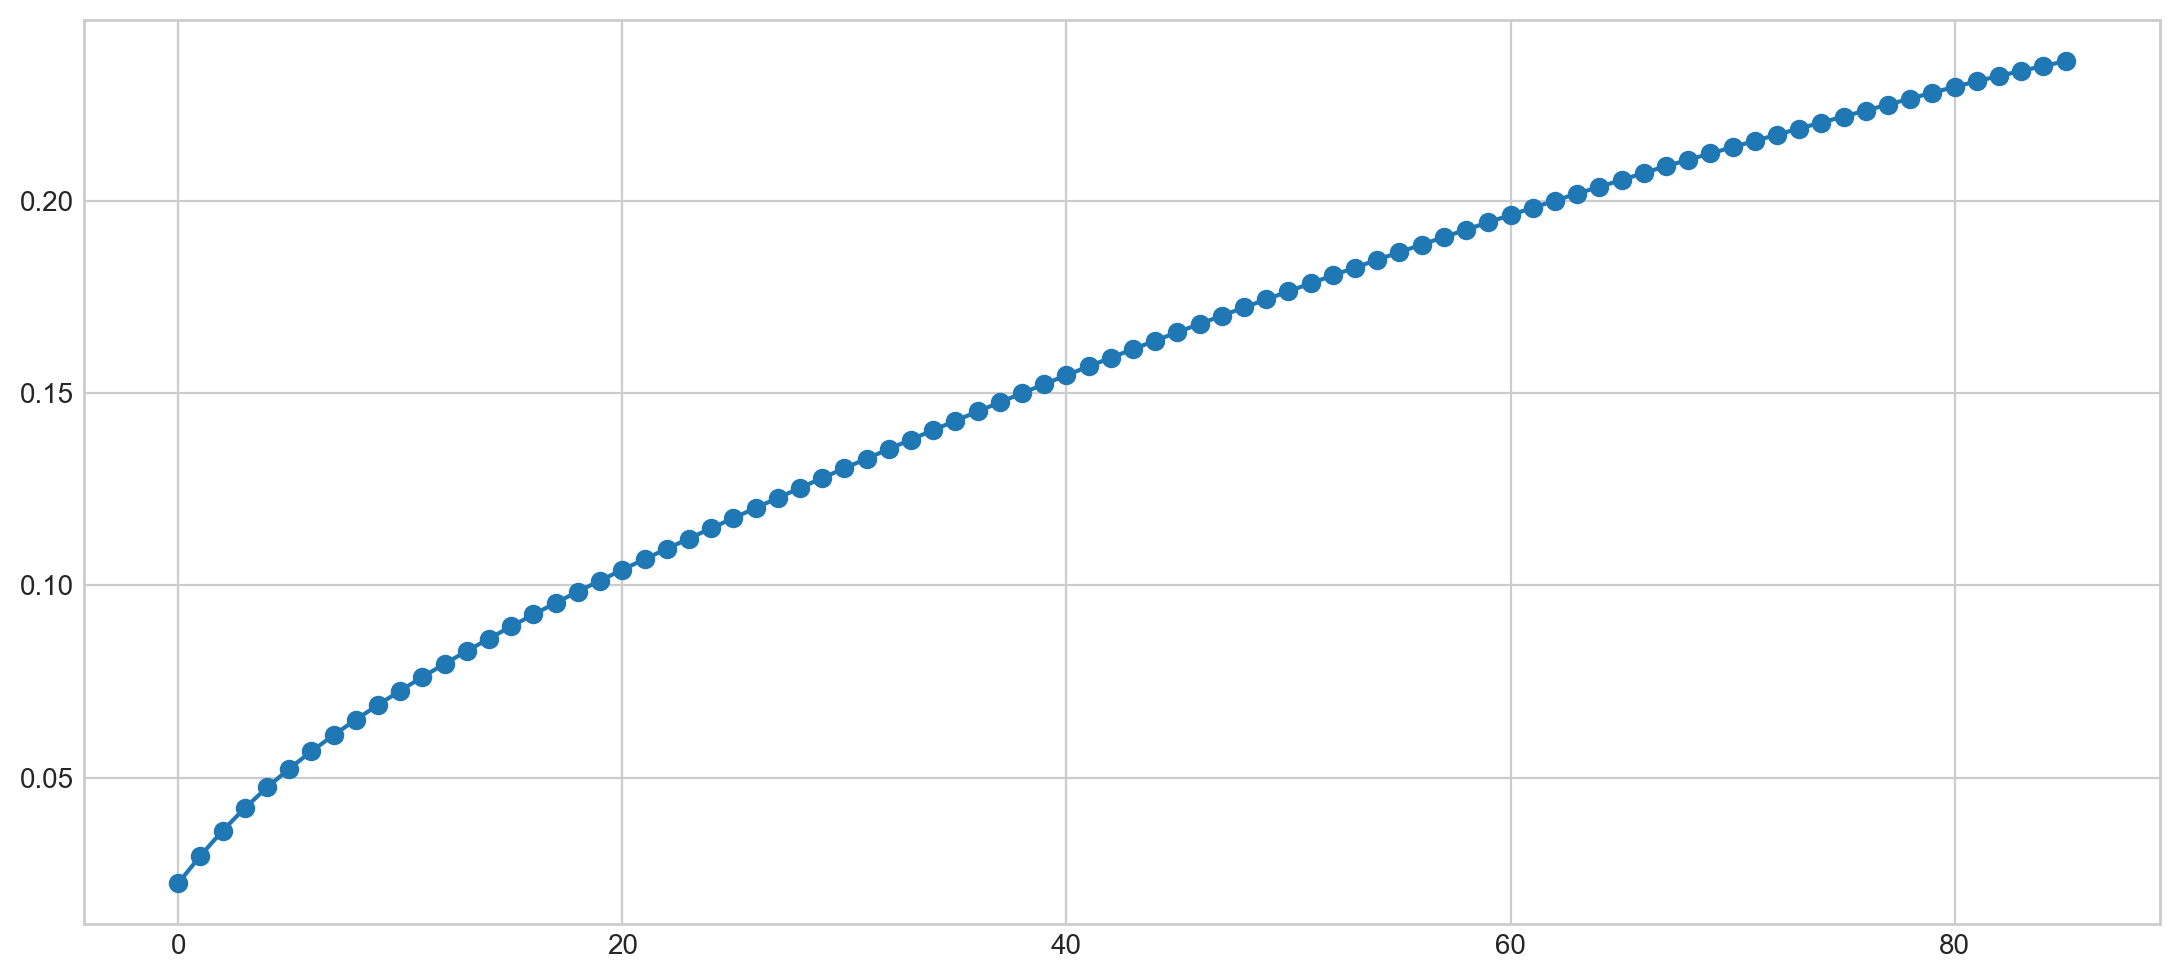

In [708]:
# plot result list

plt.plot(result_list, label="RMSE")

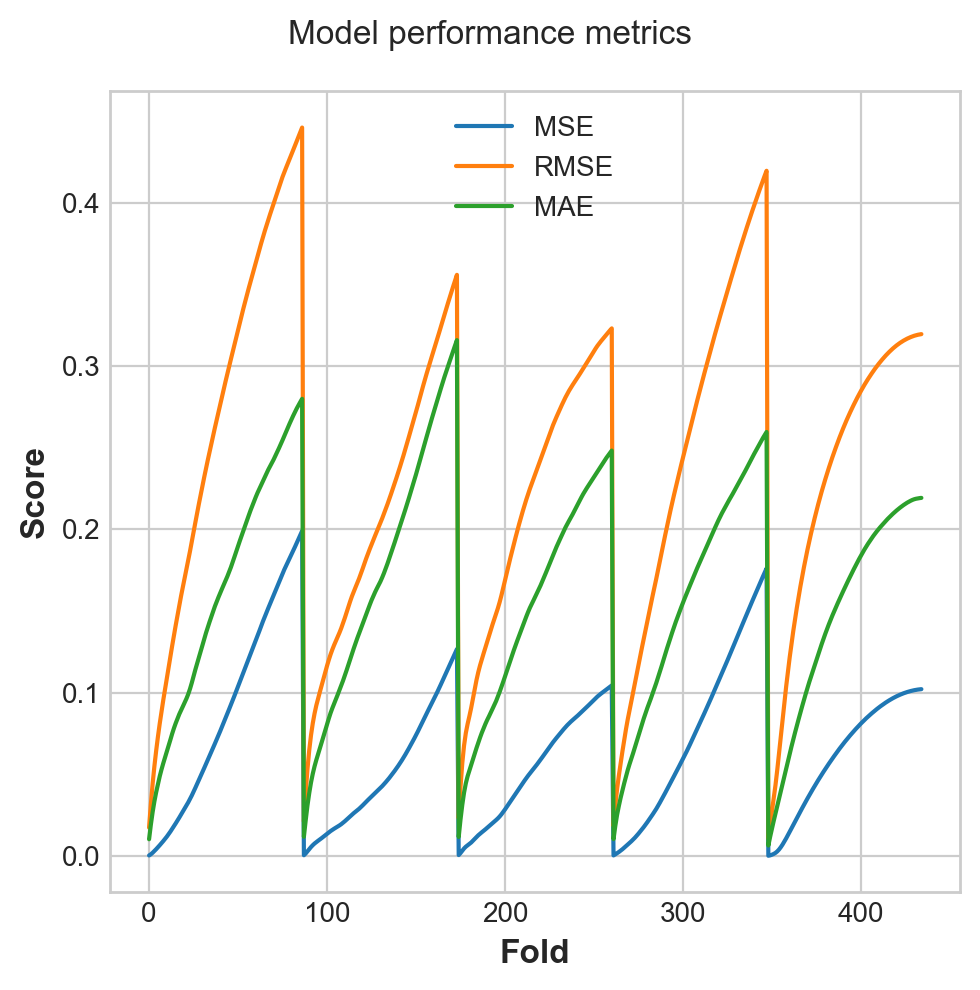

In [691]:
fig, ax = plt.subplots(figsize=(5, 5))
fig.suptitle("Model performance metrics")

ax.plot(best_results[1]["mse"], label="MSE")
ax.plot(best_results[1]["rmse"], label="RMSE")
ax.plot(best_results[1]["mae"], label="MAE")

plt.xlabel("Fold")
plt.ylabel("Score")
plt.legend(loc="best")
plt.show()

(1446,) (1446,)


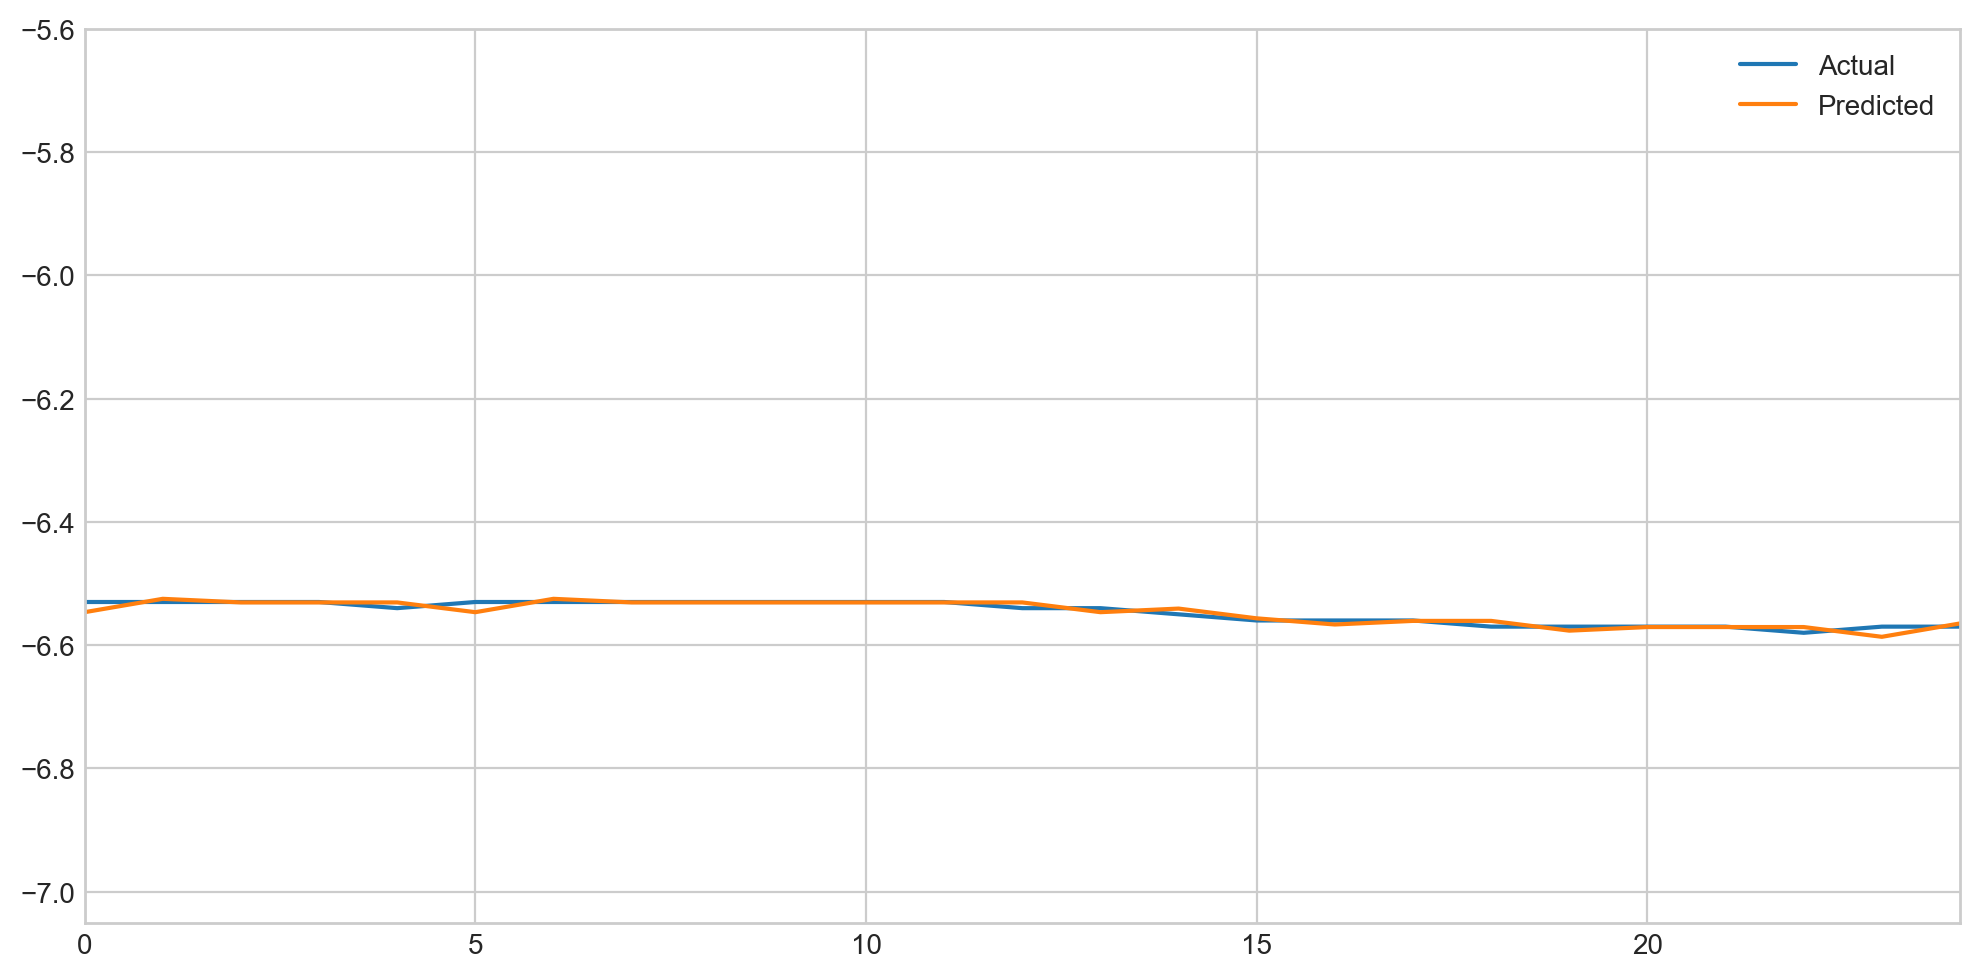

In [483]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
print(y_test.shape, y_pred.shape)
plt.plot(y_test.values, label="Actual")
plt.plot(y_pred, label="Predicted")
plt.xlim(0, 24)
plt.legend()
plt.show()

### Residual analysis


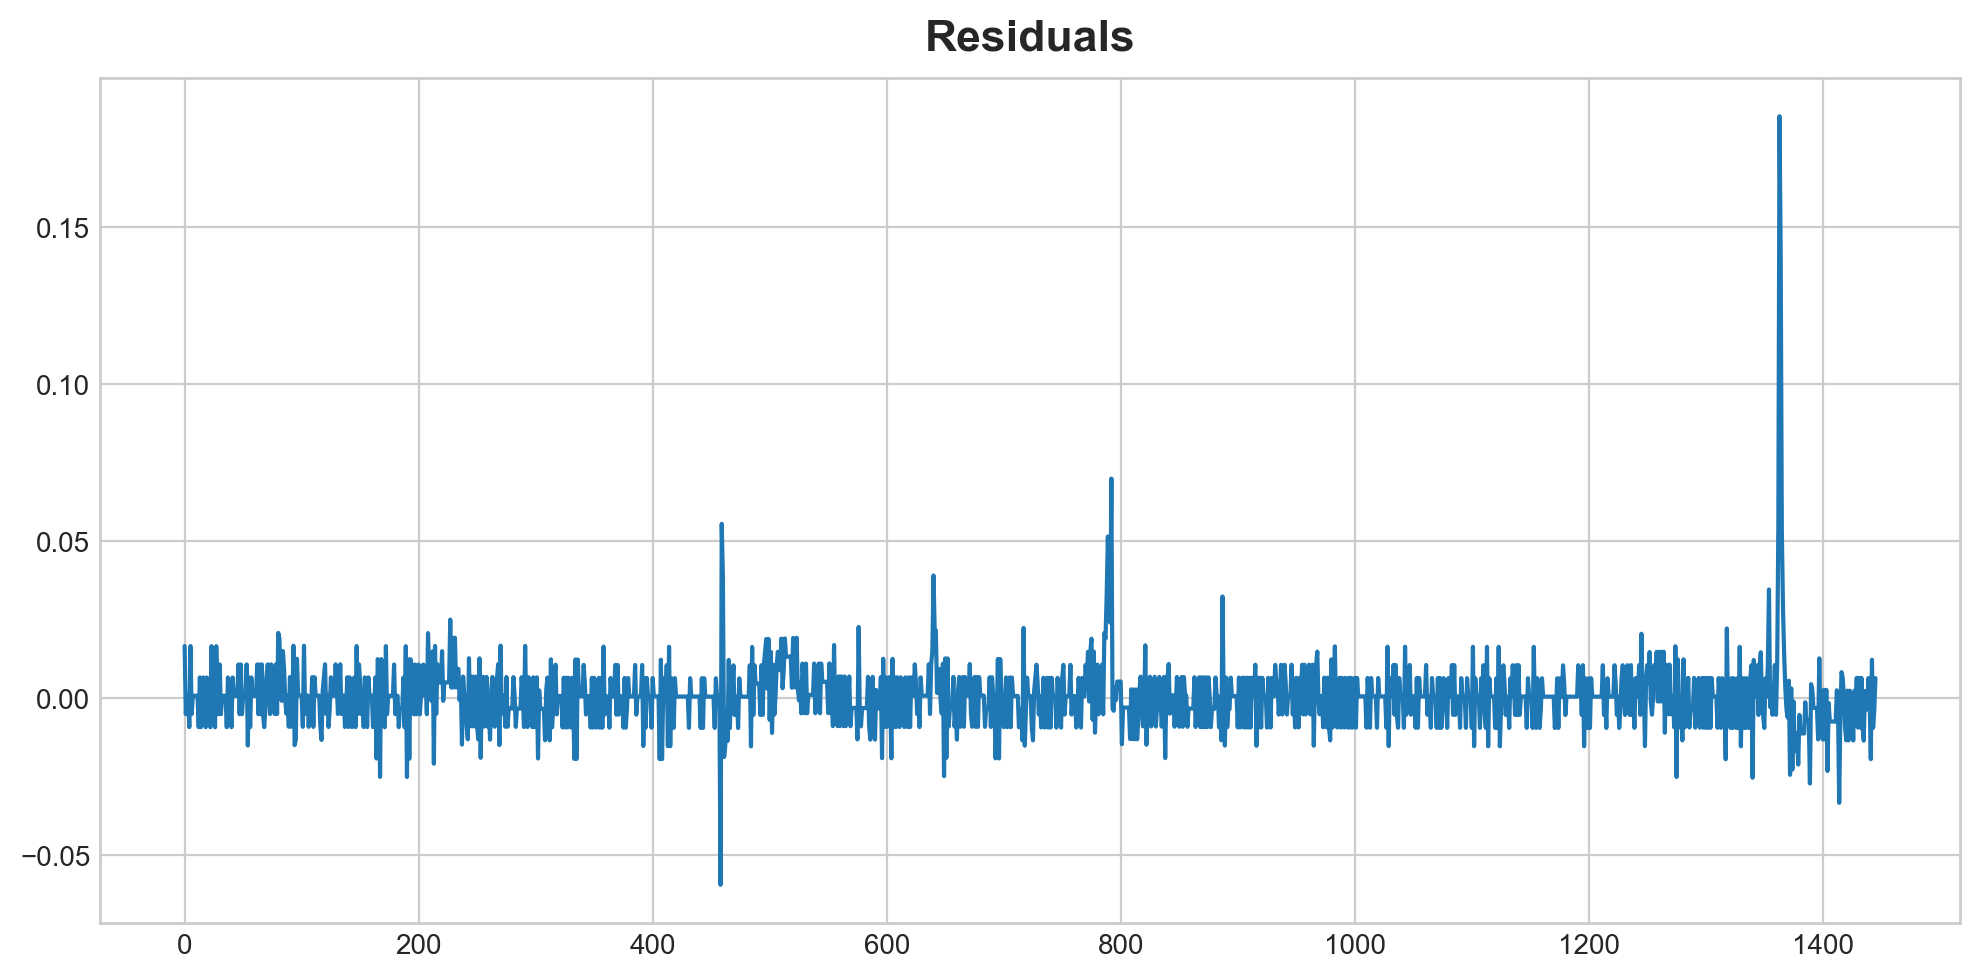

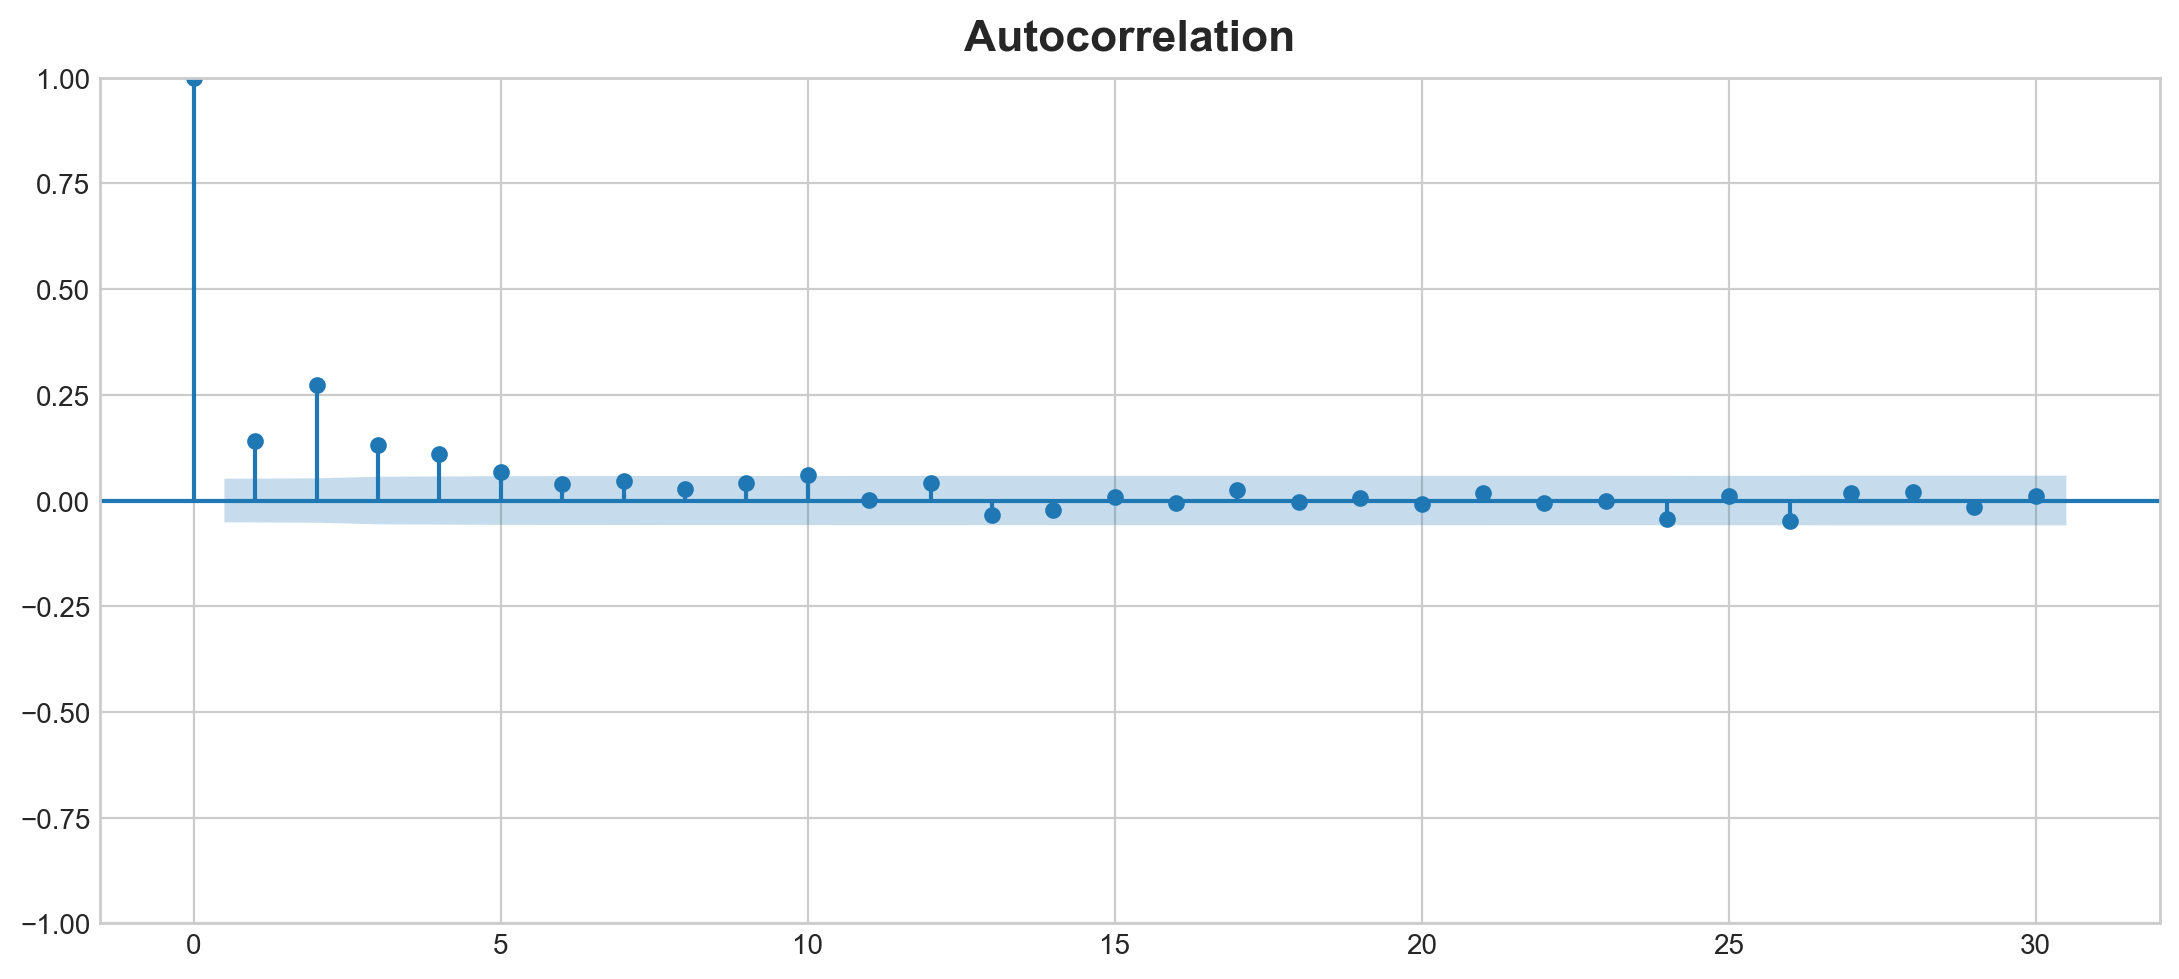

       lb_stat     lb_pvalue
30  216.234364  4.354899e-30


In [484]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox

# Compute residuals
residuals = y_test.values - y_pred

# Visual inspection
plt.figure(figsize=(10, 5))
plt.plot(residuals)
plt.title("Residuals")
plt.show()

# ACF plot
plot_acf(residuals, lags=30)
plt.show()

# Ljung-Box test
ljung_box_results = acorr_ljungbox(residuals, lags=[30])
print(ljung_box_results)

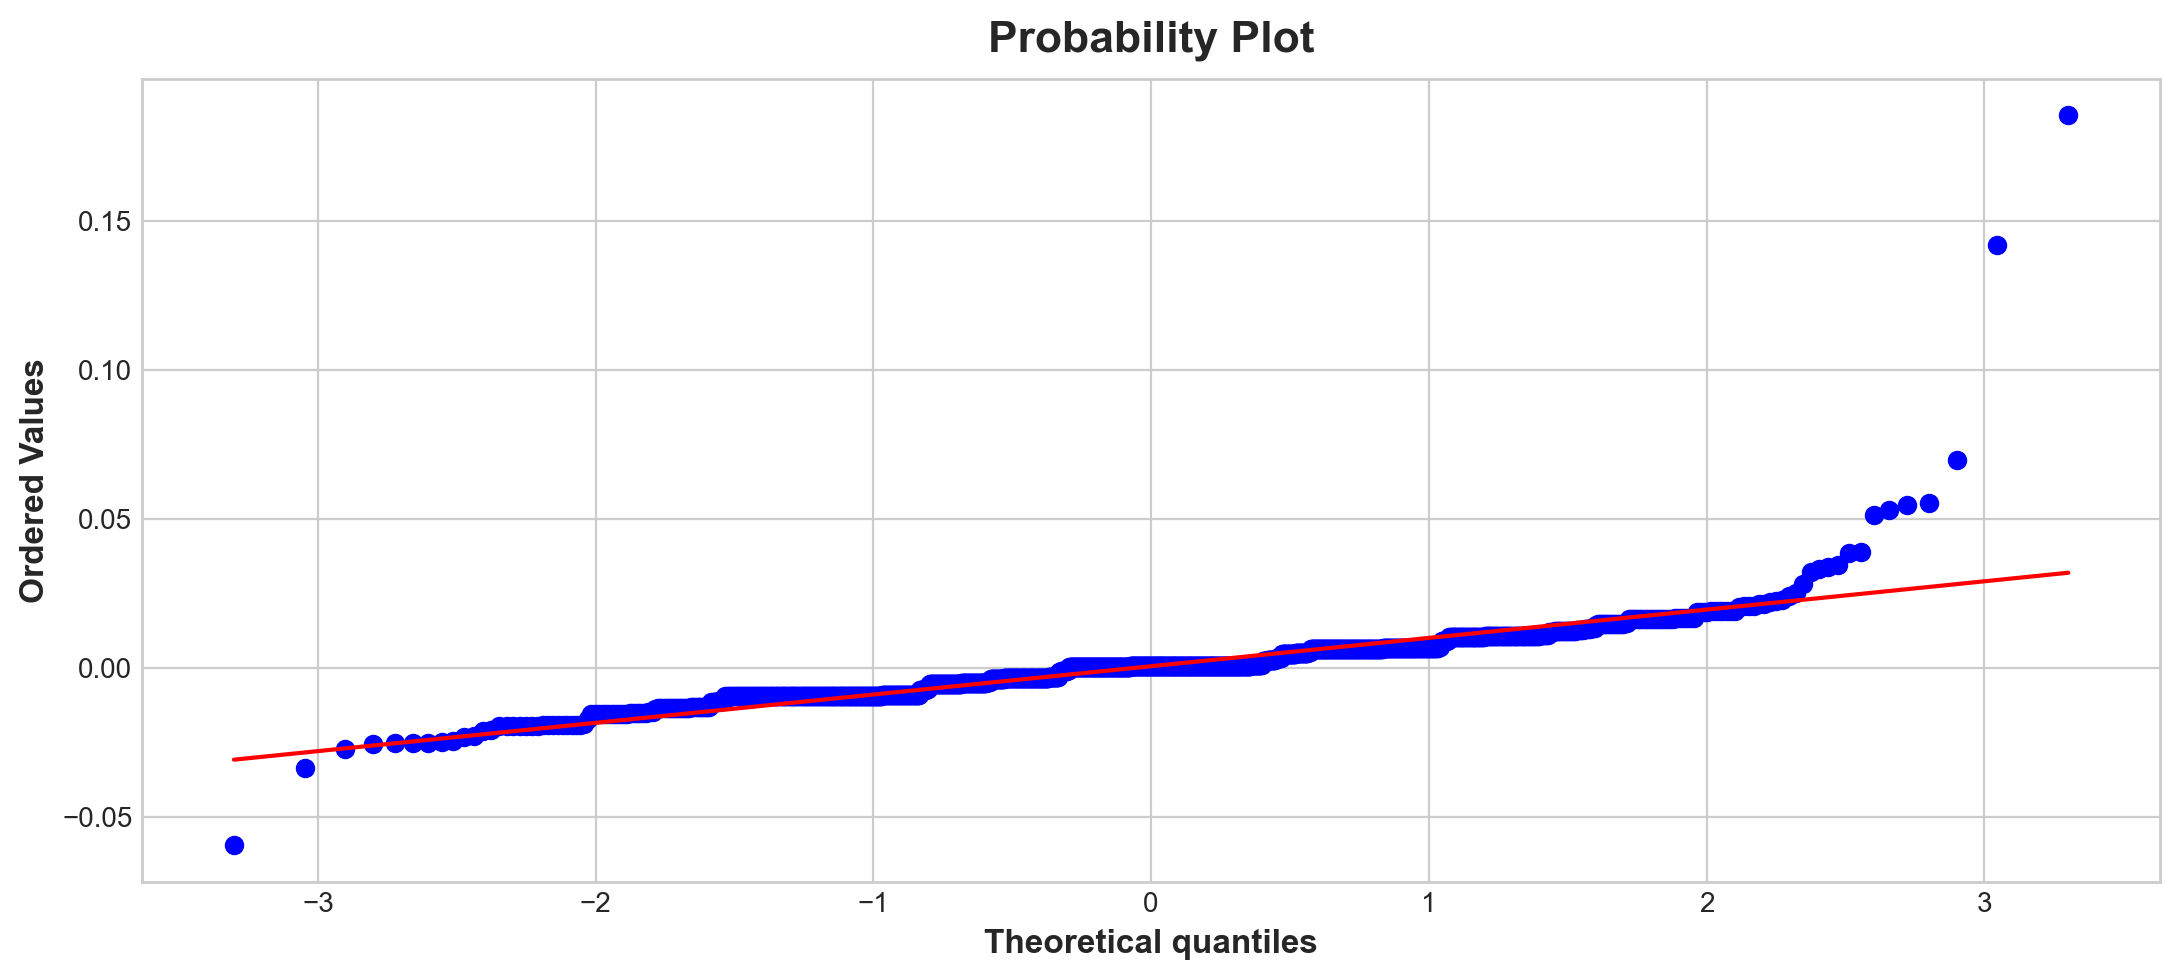

In [492]:
# plot normal probability plot

from scipy import stats

stats.probplot(residuals, plot=plt)
plt.show()

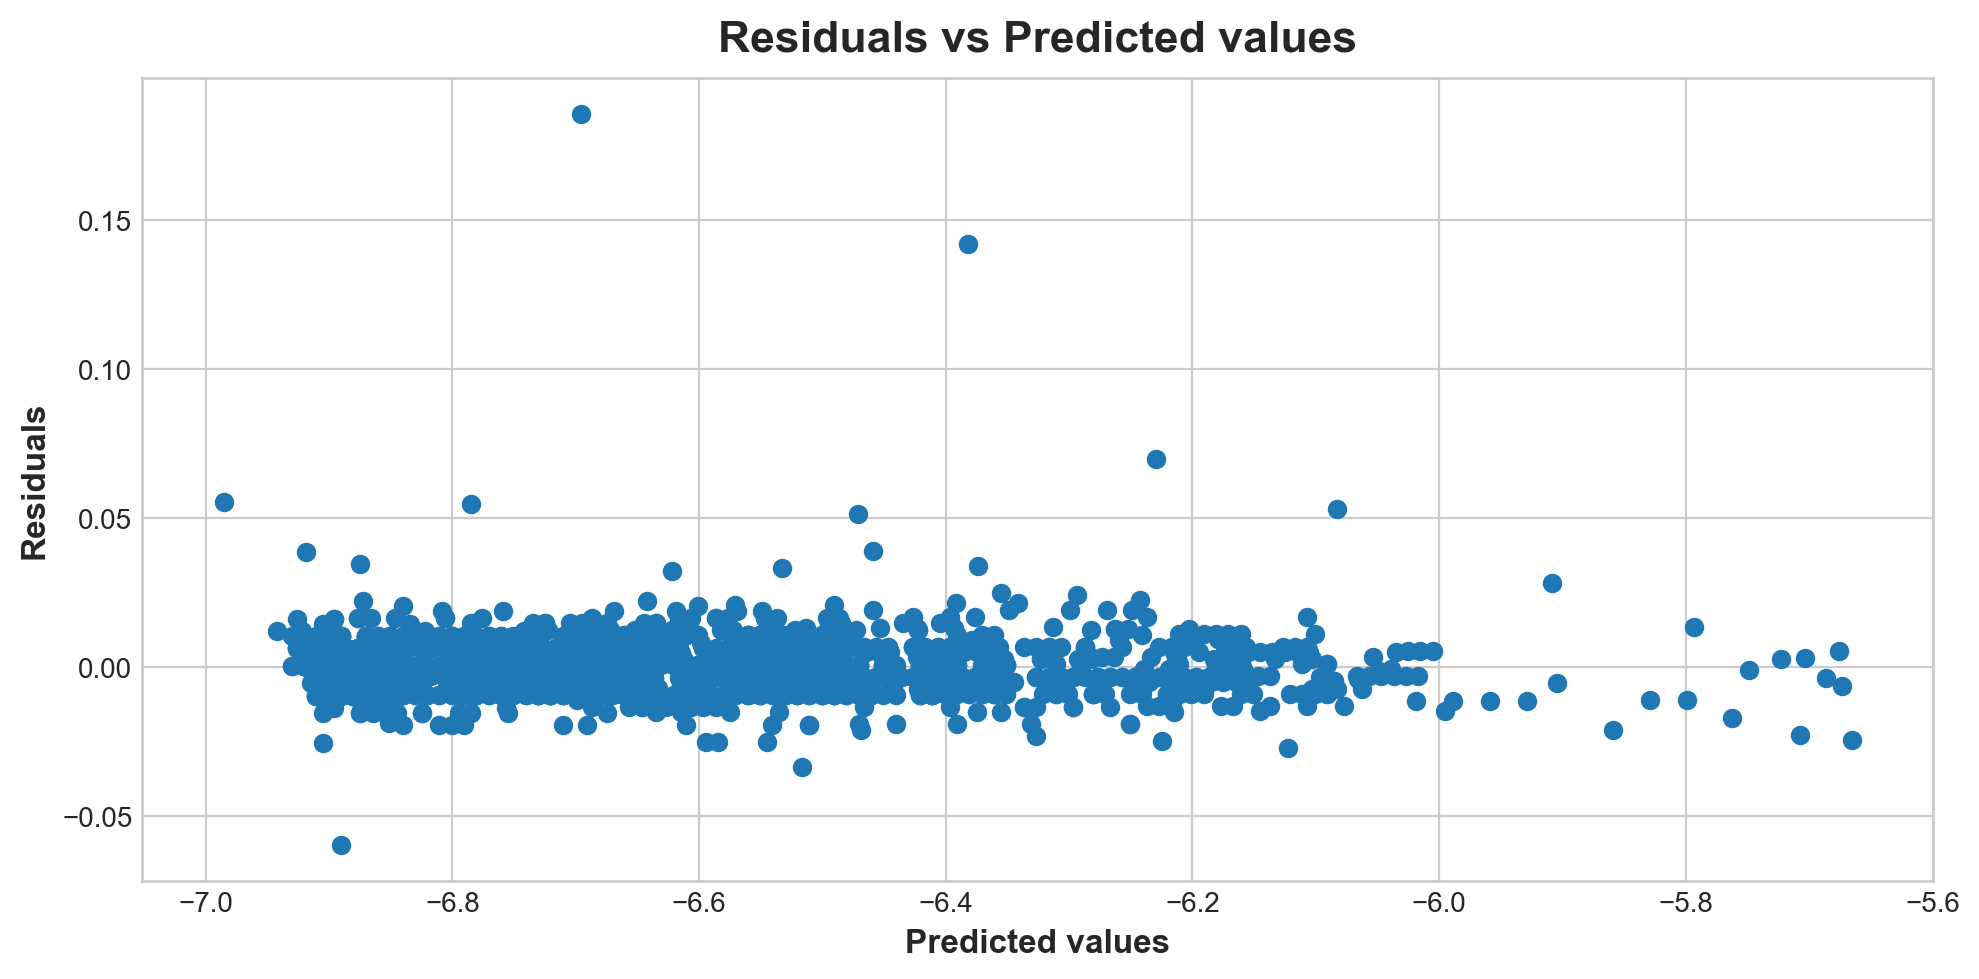

In [490]:
# plot residuals vs predicted values

plt.figure(figsize=(10, 5))
plt.scatter(y_pred, residuals)
plt.title("Residuals vs Predicted values")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.show()

### Feature importance


Feature Lag1, Score: 0.8732966792292465
Feature Lag2, Score: -0.30246627179246377


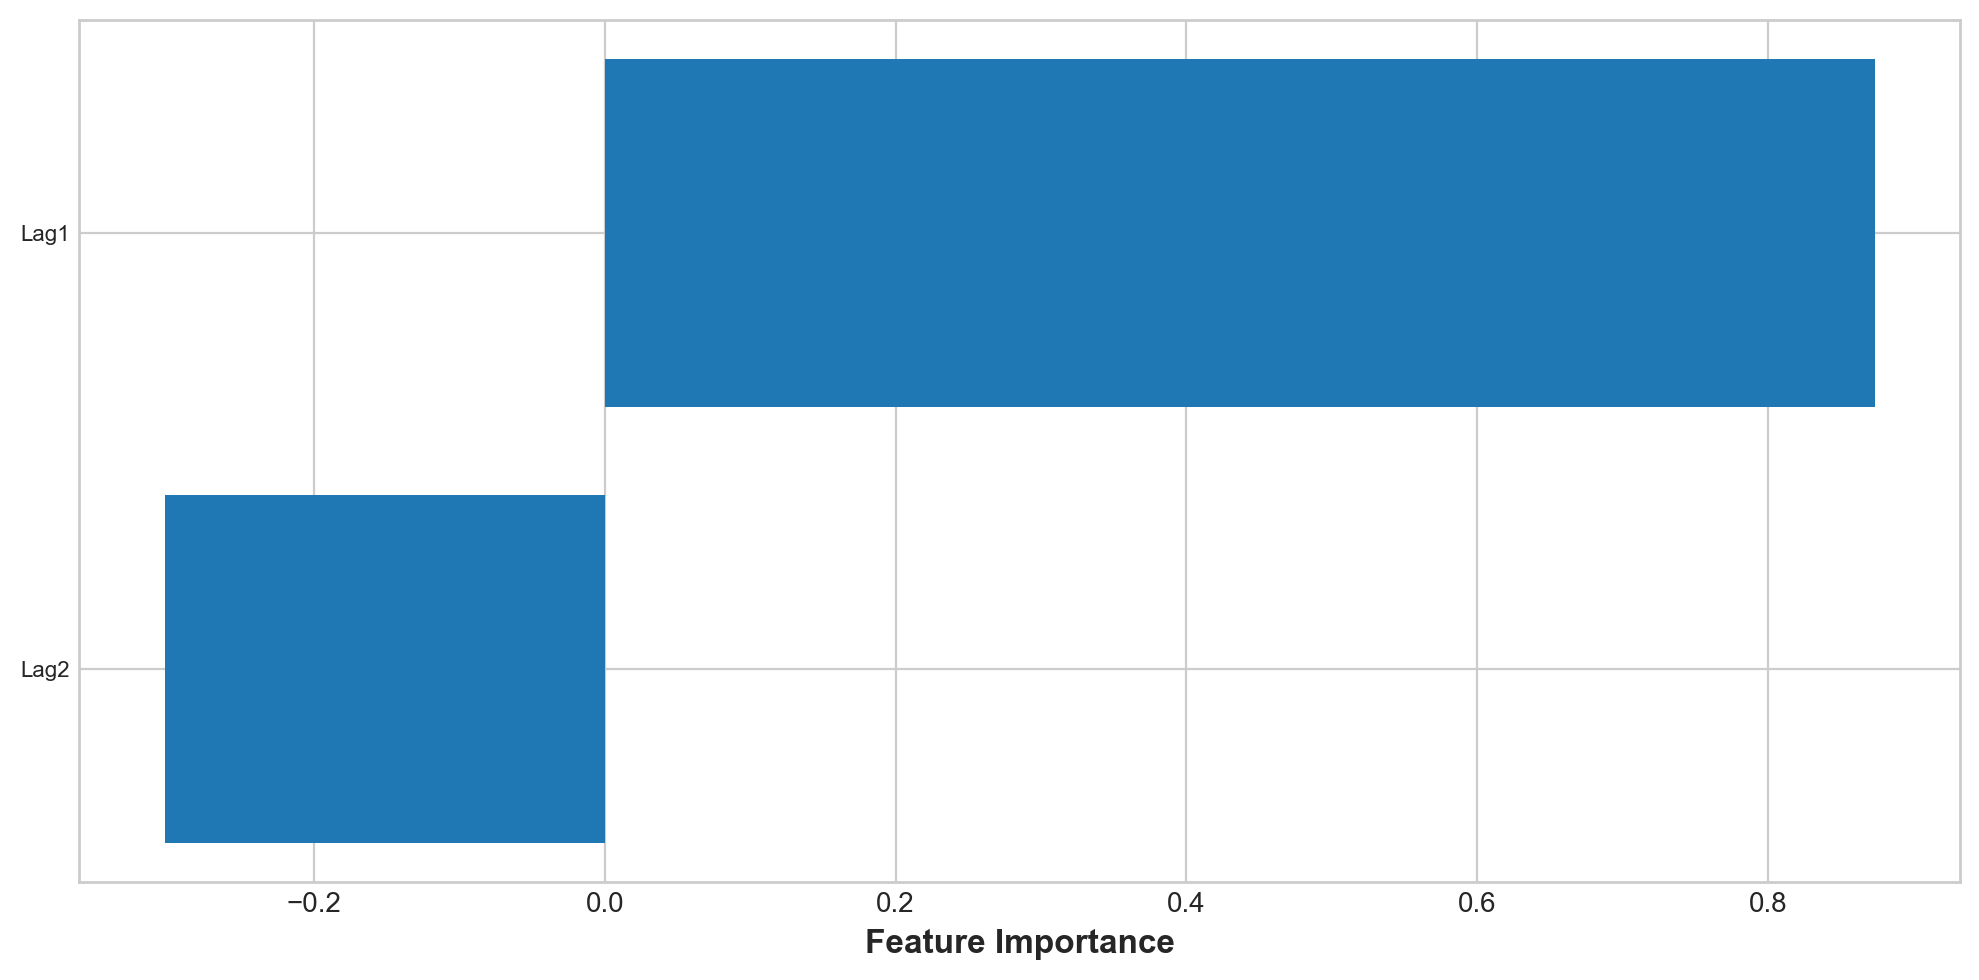

In [456]:
importance = best_results[1]["model"].coef_
feat_names = best_results[1]["model"].feature_names

for i, coef in enumerate(importance):
    print(f"Feature {feat_names[i]}, Score: {coef}")

sorted_idx = importance.argsort()
pos = np.arange(sorted_idx.shape[0]) + 0.5

featfig = plt.figure(figsize=(10, 5))
featax = featfig.add_subplot(1, 1, 1)
featax.barh(pos, importance[sorted_idx], align="center")
featax.set_yticks(pos)
featax.set_yticklabels(np.array(feat_names)[sorted_idx], fontsize=8)
featax.set_xlabel("Feature Importance")

plt.tight_layout()
plt.show()

### Cross-correlation


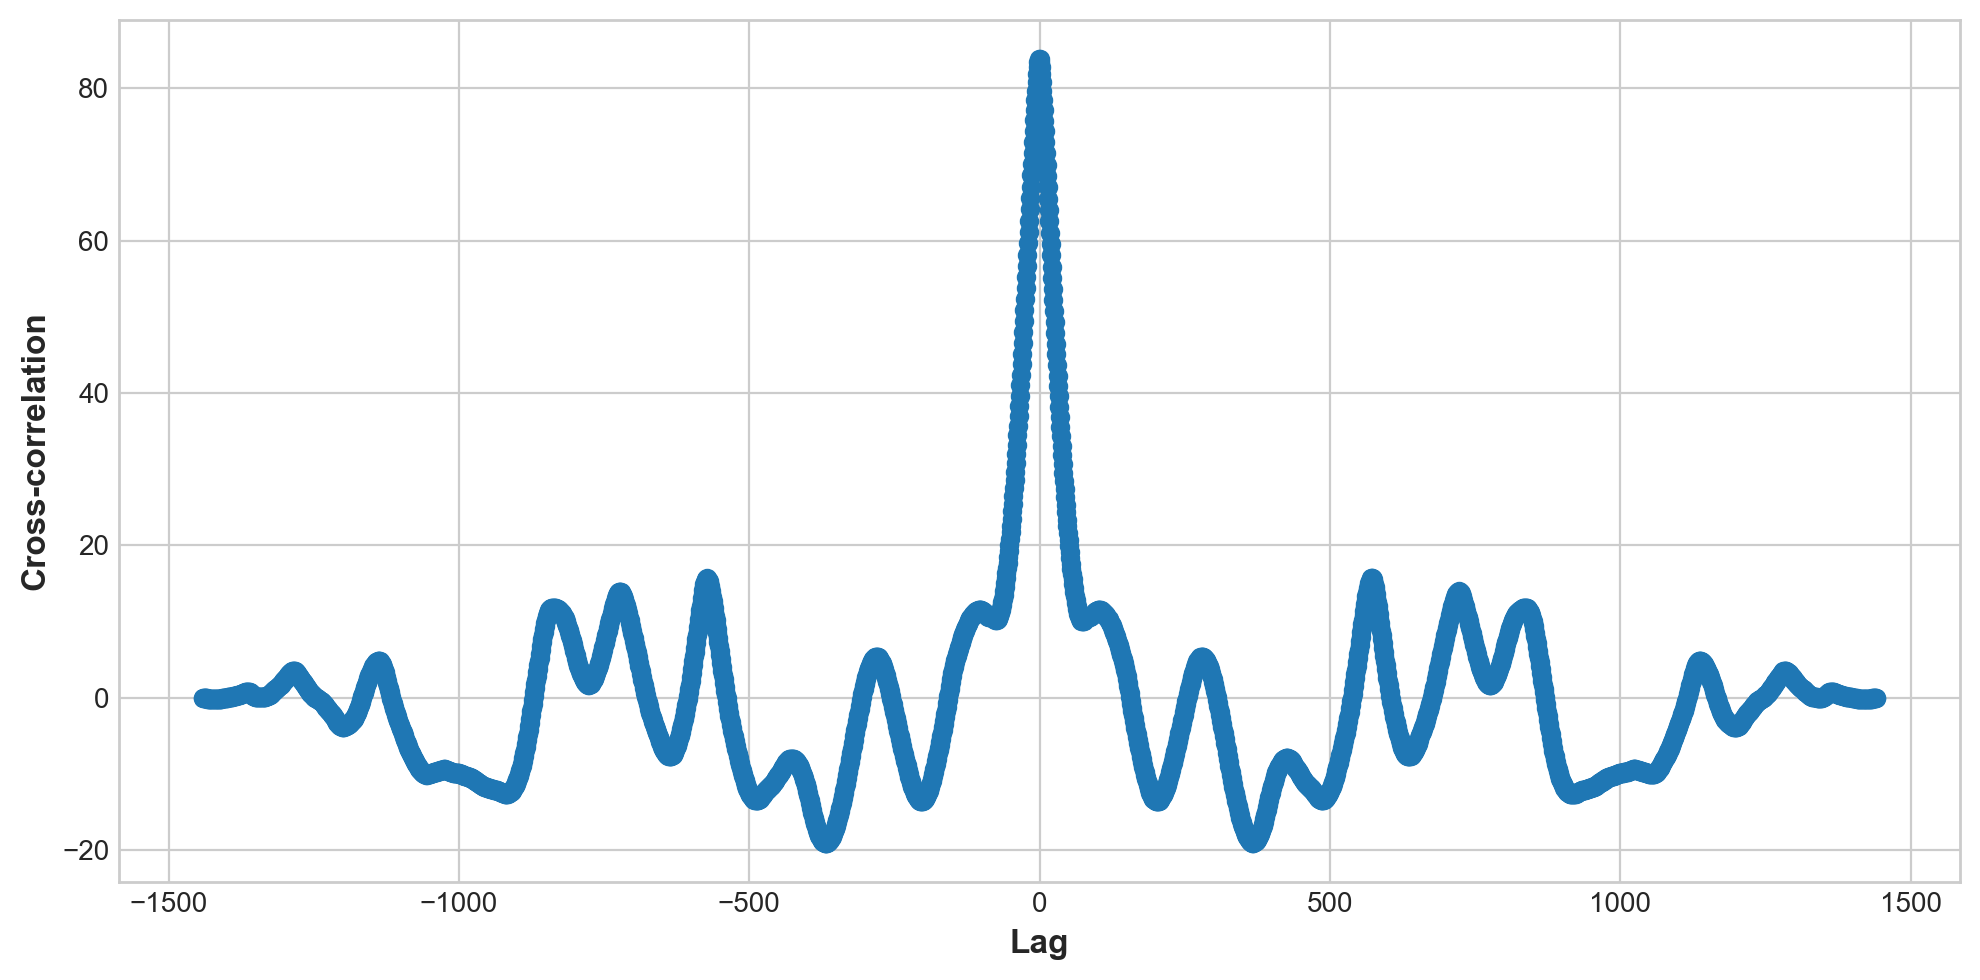

In [449]:
correlation = np.correlate(y_test - y_test.mean(), y_pred - y_pred.mean(), mode="full")

# Plot the cross-correlation
lags = np.arange(-len(y_test) + 1, len(y_test))
plt.figure(figsize=(10, 5))
plt.scatter(lags, correlation)
plt.ylabel("Cross-correlation")
plt.xlabel("Lag")
plt.show()

In [217]:
# find max lag
max_lag = lags[np.argmax(correlation)]
max_lag

-1